# 🎮 Deep RL Final Project — MiniGrid Environments

## Overview
In this project, you will train deep RL agents on two MiniGrid environments. You must implement the core algorithms yourself using concepts from class.

**Read first:** Follow the instructions in the accompanying PDF. This notebook defines the environment APIs and where you may edit.

## Learning objectives
- Implement deep RL from scratch.
- Design observation preprocessing and reward shaping.
- Evaluate performance with clear metrics and plots.
- Communicate results in a concise report.

## 🌍 The Two Environments
| Environment | Description | Actions | Goal |
|-------------|-------------|---------|------|
| **`SimpleGridEnv`** | 8×8 empty room | 3 (Left, Right, Forward) | Navigate to the green goal square |
| **`KeyDoorBallEnv`** | Two rooms with locked door | 5 (Left, Right, Forward, Pickup, Toggle) | Get key → Open door → Pick up ball → Reach goal |

## ✅ What You CAN Modify
- **Preprocessing** — Implement your own observation preprocessing function.
- **Reward shaping** — Modify rewards in each `step()` method (see `# TODO`).
- **Observation space** — Update `self.observation_space` to match preprocessing output.

## ❌ What You CANNOT Modify
- Grid layout and generation logic.
- Action spaces or termination conditions.
- Environment mechanics (door/key/ball rules).
- **No external RL libraries** for the core algorithm (you may use PyTorch/TensorFlow).

## 📦 Deliverables & Submission
**Submit:** (1) this notebook with your full code and outputs, and (2) a report formatted **as specified in the instructions PDF**.

## 🧪 Reproducibility checklist
- Set random seeds for Python, NumPy, and your DL framework.
- Document hyperparameters.

## 🧾 Academic integrity
- You may discuss ideas, but code and write-up must be your own.
- Cite any external resources (blog posts, papers, code snippets).
---

# Setup

## Installs and Imports

### Installs (run once if needed)

In [79]:
# TODO: restore before submission
# %%capture
# !sudo apt-get update
# !sudo apt-get install -y xvfb ffmpeg freeglut3-dev
# !pip install imageio
# !pip install pyvirtualdisplay
# !pip install gymnasium
# !pip install minigrid
# !pip install pygame

### Imports

In [80]:
# 1. Future Imports (Must be first)
from __future__ import annotations

# 2. Standard Library Imports
import base64
import copy
import random

# 3. Third-Party Data & Visualization Imports
import imageio
import matplotlib.pyplot as plt
import numpy as np
import IPython
from IPython.display import HTML
import pyvirtualdisplay

# 4. Gymnasium Imports
import gymnasium as gym
from gymnasium import spaces

# 5. Minigrid Imports
from minigrid.core.constants import COLOR_NAMES
from minigrid.core.grid import Grid
from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Door, Goal, Key, Lava, Wall, Ball
from minigrid.minigrid_env import MiniGridEnv as BaseMiniGridEnv

# --- Configuration ---

# Configure Matplotlib for Notebook Environment
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

### Display utils
The cell below contains the video display configuration. No need to make changes here.

In [81]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

# COLAB ONLY — restore before submission (Xvfb not available on macOS)
# display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

# Environments

> ⚠️ **Important**
>
> The two environments below are **fixed**—do not modify grid layout, action spaces, or termination conditions.
>
> **You may modify only:**
> 1. **Observation space** — set `self.observation_space` to match your preprocessing output (see `# TODO`).
> 2. **Reward shaping** — edit reward logic inside `step()` (see `# TODO`).
>
> Look for the clearly marked sections in each environment class.

In [82]:
# =============================================================================
# ENVIRONMENT 1: SIMPLE GRID (Empty Room)
# =============================================================================
class SimpleGridEnv(BaseMiniGridEnv):
    """
    A simple grid environment with no obstacles inside, just outer walls.
    The agent and goal positions are randomized at each reset.

    Actions:
        0: Turn Left
        1: Turn Right
        2: Move Forward
    """
    def __init__(
        self,
        size=10,
        max_steps=1000,
        render_mode="rgb_array",
        preprocess=None,
        **kwargs,
    ):

        # Define a static mission string (not used by the agent typically)
        mission_space = MissionSpace(mission_func=self._gen_mission)


        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            see_through_walls=True,
            max_steps=max_steps,
            render_mode=render_mode,
            highlight=False,
            **kwargs,
        )
        # Discrete actions: 0: Turn Left, 1: Turn Right, 2: Move Forward
        self.action_space = spaces.Discrete(3)

        # ╔═════════════════════════════════════════════════════════════════════╗
        # ║  ✅ STUDENT TODO: Update observation_space to match preprocessing   ║
        # ╚═════════════════════════════════════════════════════════════════════╝
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=(84, 84, 3),
            dtype=np.uint8
        )
        # ╔═════════════════════════════════════════════════════════════════════╗
        # ║                     END OF EDITABLE SECTION                         ║
        # ╚═════════════════════════════════════════════════════════════════════╝

        # Preprocessing function for observations
        self.preprocess = preprocess if preprocess is not None else lambda x: x
        self.walls_init = []
        # Default goal and agent starting position (overwritten in _gen_grid)
        self.goal_pos = (self.width - 2, self.height - 2)
        self.agent_start_pos = (1, 1)
        self.agent_start_dir = 0


    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║  ⛔ DO NOT MODIFY: Core environment methods below                       ║
    # ╚═════════════════════════════════════════════════════════════════════════╝

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def _get_obs(self, obs=None):
        """Returns the current observation after applying preprocessing."""
        obs = self.get_frame(highlight=False, tile_size=32)
        return self.preprocess(obs)

    def reset(self, *, seed=None, options=None):
        # 1. Randomize agent starting parameters before generating the grid
        self.agent_start_pos = (random.randint(1, 6), random.randint(1, 6))
        self.agent_start_dir = random.choice([0, 1, 2, 3])
        # 2. Call parent reset, which internally calls _gen_grid()
        obs, info = super().reset(seed=seed, options=options)
        # 3. Return the preprocessed observation
        return self._get_obs(obs), info

    def _gen_grid(self, width, height):
        """Procedurally generates the grid layout: walls, goal, and agent."""
        self.grid = Grid(width, height)

        # 1. Create the outer boundary walls
        self.grid.wall_rect(0, 0, width, height)

        # 2. Place internal walls (if any defined in self.walls_init)
        for column, row in self.walls_init:
            self.grid.set(column, row, Wall())

        # 3. Randomize Goal Position (Top-Right, Bottom-Right, Bottom-Left corners roughly)
        self.goal_pos = random.choice([(8,1), (8,8), (1,8)])
        self.put_obj(Goal(), self.goal_pos[0], self.goal_pos[1])

        # 4. Place Agent
        self.agent_pos = self.agent_start_pos
        self.agent_dir = self.agent_start_dir

        self.mission = "grand mission"

    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║  ✅ STUDENT TODO: Modify reward shaping below                           ║
    # ╚═════════════════════════════════════════════════════════════════════════╝
    def step(self, action):
        """
        Reward shaping (no distance signals — only discrete events & step penalty):

            +5.0   reaching the goal  (large so it clearly dominates step costs)
            -0.01  per step           (light penalty — 100-step fail = -1.0)
            -0.03  wall bump          (forward action that doesn't move the agent)

        With max_steps ≈ 100 a random agent finds the goal ~17 % of the time,
        giving enough positive-reward episodes for A2C to bootstrap from.
        A successful 40-step episode scores  -0.01*40 + 5.0 = +4.6,
        while a 100-step failure scores  -0.01*100 = -1.0.
        """
        pos_before = tuple(self.agent_pos)

        obs, reward, terminated, truncated, info = super().step(action)

        # ----- REWARD SHAPING: EDIT BELOW THIS LINE -----
        if terminated:
            reward = 5.0
        else:
            reward = -0.01  # step penalty

            # Wall bump: agent tried to move forward but didn't change position
            if action == 2 and tuple(self.agent_pos) == pos_before:
                reward = -0.03
        # ----- REWARD SHAPING: EDIT ABOVE THIS LINE -----

        return self._get_obs(obs), reward, terminated, truncated, info
    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║                     END OF EDITABLE SECTION                             ║
    # ╚═════════════════════════════════════════════════════════════════════════╝

In [83]:
# =============================================================================
# ENVIRONMENT 2: KEY-DOOR WITH BALL PICKUP
# =============================================================================
class KeyDoorBallEnv(BaseMiniGridEnv):
    """
    Grid environment with two rooms separated by a locked door.

    Task sequence:
        1. Pick up key -> 2. Unlock door -> 3. Pick up ball -> 4. Reach goal

    Actions:
        0: Turn Left
        1: Turn Right
        2: Move Forward
        3: Pick Up
        4: Toggle (open/close door)
    """
    def __init__(
        self,
        size=10,
        max_steps=1000,
        render_mode="rgb_array",
        partition_col=3,
        require_ball_pickup=True,
        preprocess=None,
        **kwargs,
    ):
        self.agent_start_pos = (1, 1)
        self.agent_start_dir = 0
        self.partition_col = partition_col
        self.walls_init = []
        self.inventory = []
        self.require_ball_pickup = require_ball_pickup
        self.preprocess = preprocess if preprocess is not None else lambda x: x

        mission_space = MissionSpace(mission_func=self._gen_mission)
        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            see_through_walls=True,
            max_steps=max_steps,
            render_mode=render_mode,
            highlight=False,
            **kwargs,
        )

        # 5 actions: left, right, forward, pickup, toggle
        self.action_space = spaces.Discrete(5)

        # ╔═════════════════════════════════════════════════════════════════════╗
        # ║  ✅ STUDENT TODO: Update observation_space to match preprocessing   ║
        # ╚═════════════════════════════════════════════════════════════════════╝
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=(84, 84, 3),
            dtype=np.uint8
        )
        # ╔═════════════════════════════════════════════════════════════════════╗
        # ║                     END OF EDITABLE SECTION                         ║
        # ╚═════════════════════════════════════════════════════════════════════╝

        # State tracking for reward shaping (you can use these in your reward logic)
        self.prev_key = False
        self.prev_door = False
        self.prev_ball = False

    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║  ⛔ DO NOT MODIFY: Core environment methods below                       ║
    # ╚═════════════════════════════════════════════════════════════════════════╝

    @staticmethod
    def _gen_mission():
        return "Pick up the key to open the door, pick up the ball, then reach the goal"

    def _get_obs(self, obs=None):
        """Returns the current observation after applying preprocessing."""
        obs = self.get_frame(highlight=False, tile_size=32)
        return self.preprocess(obs)

    def reset(self, *, seed=None, options=None):
        # Reset state tracking
        self.prev_key = False
        self.prev_door = False
        self.prev_ball = False
        self.inventory = []

        # Call parent reset, which internally calls _gen_grid()
        obs, info = super().reset(seed=seed, options=options)

        return self._get_obs(obs), info

    def _gen_grid(self, width, height):
        """Generate grid: walls, partition, door, key, ball, goal, agent."""
        # Grid with outer walls
        self.grid = Grid(width, height)
        self.grid.wall_rect(0, 0, width, height)

        # Partition wall
        self.walls_init = [(self.partition_col, i) for i in range(height)]
        for col, row in self.walls_init:
            if 0 <= col < width and 0 <= row < height:
                self.grid.set(col, row, Wall())

        # Key in left room
        self.key_pos = (
            random.choice(range(1, self.partition_col)),
            random.choice(range(2, height - 1))
        )
        self.grid.set(self.key_pos[0], self.key_pos[1], Key(COLOR_NAMES[0]))

        # Door in partition
        door_y = random.choice(range(1, height - 1))
        self.door_pos = (self.partition_col, door_y)
        self.env_door = Door(COLOR_NAMES[0], is_locked=True)
        self.grid.set(self.door_pos[0], self.door_pos[1], self.env_door)

        # Goal
        self.goal_pos = (8, 8)
        self.put_obj(Goal(), self.goal_pos[0], self.goal_pos[1])

        # Ball in right room (if required)
        if self.require_ball_pickup:
            right_x = range(self.partition_col + 2, width - 2)
            right_y = range(1, height - 1)
            while True:
                ball_x = random.choice(list(right_x))
                ball_y = random.choice(list(right_y))
                self.ball_pos = (ball_x, ball_y)
                if self.ball_pos != self.goal_pos:
                    break

            self.grid.set(ball_x, ball_y, Ball(COLOR_NAMES[1]))

        # Agent
        self.agent_pos = self.agent_start_pos
        self.agent_dir = self.agent_start_dir

    def try_pickup_ball(self):
        """Pick up ball in front and add to inventory."""
        obj = self.grid.get(self.front_pos[0], self.front_pos[1])
        if isinstance(obj, Ball):
            self.grid.set(self.front_pos[0], self.front_pos[1], None)
            self.inventory.append(obj)

    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║  ✅ STUDENT TODO: Modify reward shaping below                           ║
    # ╚═════════════════════════════════════════════════════════════════════════╝
    def step(self, action):
        """
        Step function with sparse reward.

        Available helper methods for reward shaping:
            - self.is_carrying_key()  : Returns True if agent has the key
            - self.is_carrying_ball() : Returns True if agent has the ball
            - self.is_door_open()     : Returns True if door is open
            - self.prev_key           : Key status before this step
            - self.prev_door          : Door status before this step
            - self.prev_ball          : Ball status before this step

        Current reward scheme (sparse):
            - +1.0 for reaching goal with ball
            - 0.0 otherwise

        💡 You can add reward shaping here
        """
        # Map action 4 to toggle (internal MiniGrid uses 5 for toggle)
        if action == 4:
            action = 5

        # Track previous state for reward shaping
        self.prev_key = self.is_carrying_key()
        self.prev_door = self.is_door_open()
        self.prev_ball = self.is_carrying_ball()

        # Handle ball pickup
        if action == 3:
            self.try_pickup_ball()

        # Standard step
        obs, reward, terminated, truncated, info = super().step(action)

        # Goal only counts if ball is picked up (when required)
        terminated = terminated and (not self.require_ball_pickup or self.is_carrying_ball())

        # ----- REWARD SHAPING: EDIT BELOW THIS LINE -----
        if terminated:
            reward = 1.0
        else:
            reward = 0.0
        # ----- REWARD SHAPING: EDIT ABOVE THIS LINE -----

        return self._get_obs(obs), reward, terminated, truncated, info
    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║                     END OF EDITABLE SECTION                             ║
    # ╚═════════════════════════════════════════════════════════════════════════╝

    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║  ⛔ DO NOT MODIFY: State getter methods (use these in reward shaping)   ║
    # ╚═════════════════════════════════════════════════════════════════════════╝

    def is_carrying_key(self):
        """Check if agent has key (in hand or inventory)."""
        key_in_hand = self.carrying and isinstance(self.carrying, Key)
        key_in_inventory = any(isinstance(item, Key) for item in self.inventory)
        return key_in_hand or key_in_inventory

    def is_carrying_ball(self):
        """Check if agent has ball (in hand or inventory)."""
        ball_in_hand = self.carrying and isinstance(self.carrying, Ball)
        ball_in_inventory = any(isinstance(item, Ball) for item in self.inventory)
        return ball_in_hand or ball_in_inventory

    def is_door_open(self):
        """Returns True if the door is open."""
        if hasattr(self, 'env_door'):
            return self.env_door.is_open
        return False

# Preprocessing Method

> 💡 **Student task:** Implement your own preprocessing function below.
>
> Your preprocessing function should:
> 1. Take a raw RGB image (320×320×3) as input.
> 2. Return a processed observation that **exactly matches** your `observation_space` (shape, dtype, value range).
>
> Common preprocessing techniques:
> - Crop edges to remove borders
> - Convert to grayscale
> - Resize to smaller dimensions
> - Normalize pixel values
>
> **Reminder:** Update `self.observation_space` in both environment classes to match your output.

In [84]:
import cv2

def pre_process(img):
    """
    Default preprocessing function:
        1. Crop the outer wall frame (1 cell from each edge of the 10×10 grid)
        2. Resize to 84×84
        3. Keep RGB (3 channels) — colour is critical for distinguishing
           the red agent from the green goal.

    Args:
        img: RGB image from MiniGrid renderer, shape (H, W, 3).
             H = W = grid_size * tile_size  (e.g. 320 for tile_size=32).

    Returns:
        RGB image (84, 84, 3) with values 0–255 (uint8).
    """
    h, w = img.shape[:2]

    # 1. Crop outer wall frame: 1/10 margin on each side (for 10×10 grid)
    margin = h // 10
    cropped = img[margin : h - margin, margin : w - margin]

    # 2. Resize to 84×84 (keep RGB)
    resized = cv2.resize(cropped, (84, 84), interpolation=cv2.INTER_AREA)

    return resized  # (84, 84, 3)

# 🔍 Environment Examples & Exploration
Run the cells below to understand each environment before implementing your solution.
Use these quick tests to verify preprocessing output shape and rendering.

## Environment 1: SimpleGridEnv (Empty Room)

**Task**: Navigate to the green goal square in an empty 8×8 room.

| Property | Value |
|----------|-------|
| Grid Size | 8×8 |
| Agent Start | Random position (1-6, 1-6) |
| Agent Direction | Random (0-3) |
| Goal Position | Random: (8,1), (1,8), or (8,8) |
| Actions | 0: Turn Left, 1: Turn Right, 2: Move Forward |
| Sparse Reward | +1.0 on reaching goal, 0.0 otherwise |

### Quick Test

=== SimpleGridEnv ===
Action space:       Discrete(3)
Number of actions:  3
Observation space:  Box(0, 255, (84, 84, 3), uint8)  (ensure it matches preprocessing output)
Observation shape:  (84, 84, 3)
Agent direction:    2
Agent position:     (3, 5)
Goal position:      (1, 8)


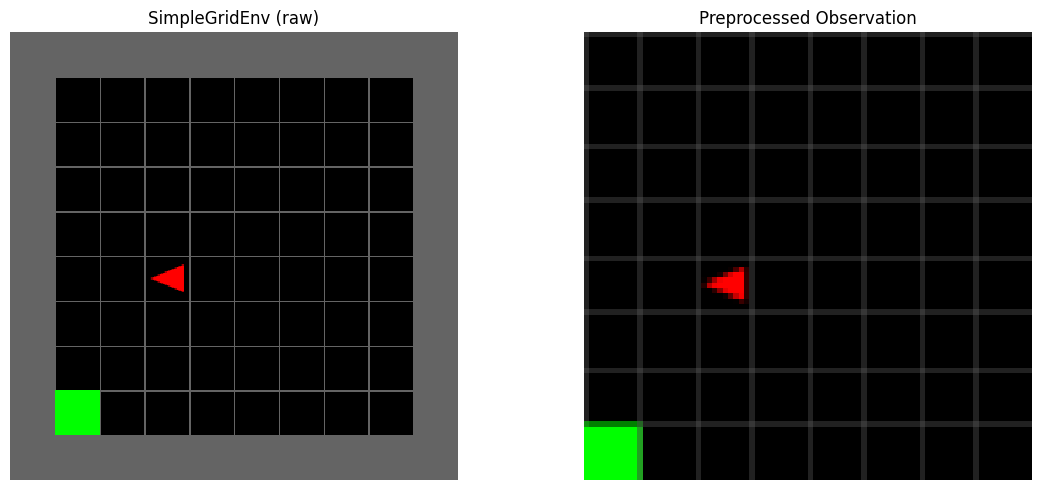

In [85]:
# Initialize environment with preprocessing
env = SimpleGridEnv(max_steps=100, preprocess=pre_process)
obs = env.reset()[0]

print("=== SimpleGridEnv ===")
print(f"Action space:       {env.action_space}")
print(f"Number of actions:  {env.action_space.n}")
print(f"Observation space:  {env.observation_space}  (ensure it matches preprocessing output)")
print(f"Observation shape:  {obs.shape}")
print(f"Agent direction:    {env.agent_dir}")
print(f"Agent position:     {env.agent_pos}")
print(f"Goal position:      {env.goal_pos}")

# Side-by-side view of raw and preprocessed observations
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(env.render())
axes[0].set_title("SimpleGridEnv (raw)")
axes[0].axis("off")
axes[1].imshow(obs.squeeze(), cmap="gray")
axes[1].set_title("Preprocessed Observation")
axes[1].axis("off")
plt.tight_layout()
plt.show()

## Environment 2: KeyDoorBallEnv (Key-Door-Ball Task)

**Task**: Complete a multi-step objective: Key → Door → Ball → Goal

| Property | Value |
|----------|-------|
| Grid Size | 8×8 (two rooms) |
| Partition Wall | Column 3 |
| Key Location | Left room (random) |
| Door Location | In partition wall (random row) |
| Ball Location | Right room (random) |
| Goal Position | Fixed at (8, 8) |
| Actions | 0: Left, 1: Right, 2: Forward, 3: Pickup, 4: Toggle |

**Sequence**: Pick up key → Open door → Enter right room → Pick up ball → Reach goal

**Helper Methods** (use in reward shaping):
- `is_carrying_key()` — True if agent has the key
- `is_carrying_ball()` — True if agent has the ball
- `is_door_open()` — True if door is open

### Quick Test

=== KeyDoorBallEnv ===
Action space:       Discrete(5)
Number of actions:  5
Observation space:  Box(0, 255, (84, 84, 3), uint8)  (ensure it matches preprocessing output)
Observation shape:  (84, 84, 3)
Agent direction:    0
Agent position:     (1, 1)
Goal position:      (8, 8)
Carrying key:       False
Door open:          False
Carrying ball:      False


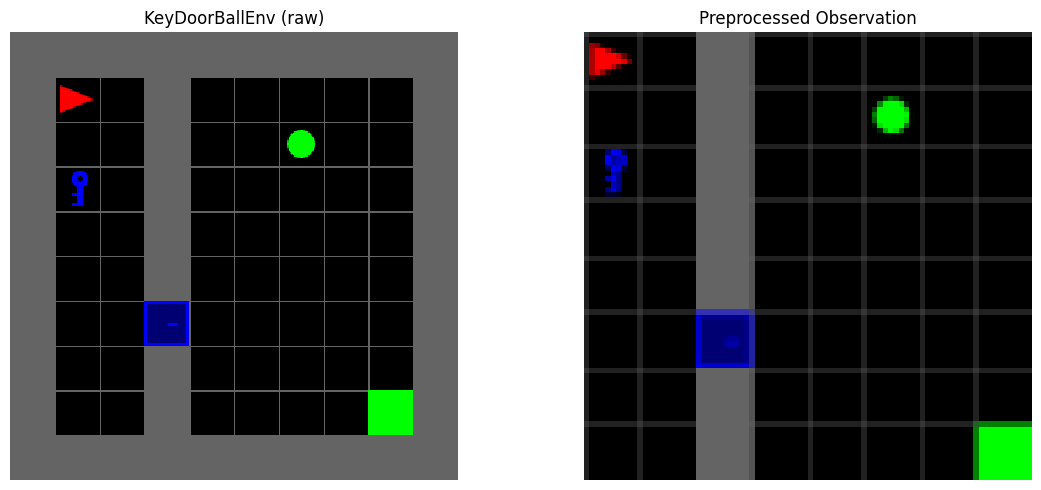

In [86]:
# Initialize environment
env = KeyDoorBallEnv(max_steps=5000, preprocess=pre_process)
obs = env.reset()[0]

print("=== KeyDoorBallEnv ===")
print(f"Action space:       {env.action_space}")
print(f"Number of actions:  {env.action_space.n}")
print(f"Observation space:  {env.observation_space}  (ensure it matches preprocessing output)")
print(f"Observation shape:  {obs.shape}")
print(f"Agent direction:    {env.agent_dir}")
print(f"Agent position:     {env.agent_pos}")
print(f"Goal position:      {env.goal_pos}")
print(f"Carrying key:       {env.is_carrying_key()}")
print(f"Door open:          {env.is_door_open()}")
print(f"Carrying ball:      {env.is_carrying_ball()}")

# Side-by-side view of raw and preprocessed observations
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(env.render())
axes[0].set_title("KeyDoorBallEnv (raw)")
axes[0].axis("off")
axes[1].imshow(obs.squeeze(), cmap="gray")
axes[1].set_title("Preprocessed Observation")
axes[1].axis("off")
plt.tight_layout()
plt.show()

In [87]:
# COLAB ONLY — restore before submission (/content/ path doesn't exist on macOS)
# # Random action rollout + video
# max_steps = 100
# env = KeyDoorBallEnv(max_steps=max_steps, preprocess=pre_process)
# num_actions = env.action_space.n
# obs = env.reset()[0]
# video_filename = "/content/KeyDoorBallEnv_random.mp4"
#
# with imageio.get_writer(video_filename, fps=10) as video:
#     obs, _ = env.reset()
#     done = False
#     total_reward = 0
#     for step in range(max_steps):
#         action = random.randint(0, num_actions - 1)
#         obs, reward, terminated, truncated, _ = env.step(action)
#         done = terminated or truncated
#         total_reward += reward
#         video.append_data(env.render())
#         if done:
#             break
#
# # Print episode summary
# print("=== Episode Summary ===")
# print(f"Steps:         {step + 1}")
# print(f"Total reward:  {total_reward:.3f}")
# print(f"Terminated:    {terminated}")
# print(f"Truncated:     {truncated}")
# print()
# print("=== Environment Status (End of Episode) ===")
# print(f"Agent position:  {env.agent_pos}")
# print(f"Carrying key:    {env.is_carrying_key()}")
# print(f"Door open:       {env.is_door_open()}")
# print(f"Carrying ball:   {env.is_carrying_ball()}")
#
# embed_mp4(video_filename)

# 1. Networks

In [88]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def obs_to_tensor(obs, device):
    """
    Convert a preprocessed numpy observation to a batched tensor in (N, C, H, W) format.
    Normalises uint8 pixels from [0, 255] to [0, 1] — critical for CNN convergence
    (Kaiming-initialised weights assume ~unit-variance inputs).

    Args:
        obs: numpy array of shape (H, W, C), e.g. (84, 84, 3), dtype uint8
        device: torch device

    Returns:
        Tensor of shape (1, C, H, W) on the given device, values in [0, 1]
    """
    # (H, W, C) -> (C, H, W), convert to float32 and normalise to [0, 1]
    t = torch.from_numpy(obs.transpose(2, 0, 1).astype(np.float32, copy=False))
    t = t.mul_(1.0 / 255.0)  # in-place: [0,255] -> [0,1]
    return t.unsqueeze(0).to(device)


class CNNFeatureExtractor(nn.Module):
    """
    CNN for extracting features from preprocessed grid-world images.

    Uses small 3×3 kernels with stride 2 to capture fine spatial detail
    (agent triangle, goal square) in the sparse 84×84 grayscale images.
    Inputs are expected in [0, 1] (via obs_to_tensor normalisation).

    Input:  (batch, 3, 84, 84)  — channels-first RGB, values in [0, 1]
    Output: (batch, feature_dim)

    Architecture:
        Conv1 + ReLU: 32 × 3×3, stride 2, pad 1 → 42×42
        Conv2 + ReLU: 64 × 3×3, stride 2, pad 1 → 21×21
        Conv3 + ReLU: 64 × 3×3, stride 2, pad 1 → 11×11
        Conv4 + ReLU: 64 × 3×3, stride 2, pad 1 →  6×6
        Flatten → 2304
        FC + ReLU → feature_dim
    """

    def __init__(self, input_channels=3, feature_dim=256):
        super().__init__()

        self.conv1 = nn.Conv2d(input_channels, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, stride=2, padding=1)

        # 64 * 6 * 6 = 2304  (84 → 42 → 21 → 11 → 6)
        self.fc = nn.Linear(64 * 6 * 6, feature_dim)
        self.feature_dim = feature_dim

    def forward(self, x):
        """
        Args:
            x: Float tensor of shape (batch, C, H, W).

        Returns:
            Feature vector of shape (batch, feature_dim)
        """
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc(x))
        return x



# 2. Utils

In [89]:
import os


# ---------------------------------------------------------------------------
# Reproducibility & device
# ---------------------------------------------------------------------------

SEED = 42

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
print(f"Device: {device}")


# ---------------------------------------------------------------------------
# Plotting
# ---------------------------------------------------------------------------

def plot_training(history, title="Training", save_path=None):
    """
    Unified 2x2 training-curve plot for any algorithm (DQN, A2C, REINFORCE...).

    Top row  — Rewards & Steps (always present).
    Bottom-left  — Loss: DQN 'losses' OR A2C 'actor_losses' + 'critic_losses'.
    Bottom-right — DQN 'epsilons' OR A2C 'avg_entropy'.
    Panels with no data are hidden automatically.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    window = min(100, max(1, len(history["episode_rewards"]) // 10))
    kernel = np.ones(window) / window if window > 0 else None

    def _smooth(ax, data, color, ylabel, subtitle, xlabel="Episode"):
        ax.plot(data, alpha=0.2, color=color)
        if kernel is not None and len(data) >= window:
            sm = np.convolve(data, kernel, mode="valid")
            ax.plot(range(window-1, len(data)), sm, color=color, label=f"{window}-ep avg")
            ax.legend()
        ax.set_xlabel(xlabel); ax.set_ylabel(ylabel)
        ax.set_title(f"{title} — {subtitle}"); ax.grid(True, alpha=0.3)

    # ── top row: rewards + steps ────────────────────────────────────
    _smooth(axes[0,0], history["episode_rewards"], "tab:blue", "Reward", "Rewards")
    _smooth(axes[0,1], history["episode_steps"], "tab:orange", "Steps", "Steps / Episode")

    # ── bottom-left: loss ───────────────────────────────────────────
    if history.get("losses"):
        _smooth(axes[1,0], history["losses"], "tab:red", "Loss", "Huber Loss")
    elif history.get("actor_losses"):
        ax = axes[1,0]
        ax.plot(history["actor_losses"], alpha=0.15, color="tab:red")
        ax.plot(history["critic_losses"], alpha=0.15, color="tab:purple")
        if kernel is not None and len(history["actor_losses"]) >= window:
            sm_a = np.convolve(history["actor_losses"], kernel, mode="valid")
            sm_c = np.convolve(history["critic_losses"], kernel, mode="valid")
            x = range(window-1, len(history["actor_losses"]))
            ax.plot(x, sm_a, color="tab:red",   label=f"Actor  ({window}-avg)")
            ax.plot(x, sm_c, color="tab:purple", label=f"Critic ({window}-avg)")
        ax.set_xlabel("Update step"); ax.set_ylabel("Loss")
        ax.set_title(f"{title} — Losses"); ax.legend(); ax.grid(True, alpha=0.3)
    else:
        axes[1,0].set_visible(False)

    # ── bottom-right: epsilon or entropy ────────────────────────────
    if history.get("epsilons"):
        ax = axes[1,1]
        ax.plot(history["epsilons"], color="tab:green")
        ax.set_xlabel("Episode"); ax.set_ylabel("Epsilon")
        ax.set_title(f"{title} — Epsilon Schedule"); ax.grid(True, alpha=0.3)
    elif history.get("avg_entropy"):
        ax = axes[1,1]
        ax.plot(history["avg_entropy"], color="tab:green")
        ax.set_xlabel("Update step"); ax.set_ylabel("Entropy")
        ax.set_title(f"{title} — Policy Entropy"); ax.grid(True, alpha=0.3)
    else:
        axes[1,1].set_visible(False)

    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path) or ".", exist_ok=True)
        plt.savefig(save_path, dpi=150, bbox_inches="tight"); plt.close()
    else:
        plt.show()

# ---------------------------------------------------------------------------
# Evaluation
# ---------------------------------------------------------------------------

def evaluate_agent(agent, env_class, num_episodes=100, max_steps=200,
                   tile_size=10):
    """
    Evaluate a trained agent over multiple episodes.

    The agent must expose ``select_action(obs) -> int``.

    Args:
        agent: trained agent (or None for random baseline)
        env_class: environment class (SimpleGridEnv / KeyDoorBallEnv)
        num_episodes: number of evaluation episodes
        max_steps: max steps per episode
        tile_size: tile size for rendering (smaller = faster)

    Returns:
        dict with keys: num_episodes, avg_reward, std_reward, avg_steps,
        std_steps, success_rate, min_steps, max_steps, all_rewards, all_steps
    """
    env = env_class(preprocess=pre_process, max_steps=max_steps, tile_size=tile_size)

    episode_rewards = []
    episode_steps = []
    successes = 0

    for ep in range(num_episodes):
        obs, _ = env.reset()
        total_reward = 0.0

        for step in range(max_steps):
            if agent is None:
                action = env.action_space.sample()
            else:
                action = agent.select_action(obs)

            obs, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward

            if terminated:
                successes += 1
                break
            if truncated:
                break

        episode_rewards.append(total_reward)
        episode_steps.append(step + 1)

        # Progress bar
        done = ep + 1
        pct = done / num_episodes
        bar_len = 30
        filled = int(bar_len * pct)
        bar = "█" * filled + "░" * (bar_len - filled)
        print(
            f"\rEvaluating: |{bar}| {done}/{num_episodes} "
            f"({pct*100:.0f}%) success so far: {successes}/{done}",
            end="",
            flush=True,
        )

    print()  # newline after progress bar
    env.close()

    return {
        "num_episodes": num_episodes,
        "avg_reward": np.mean(episode_rewards),
        "std_reward": np.std(episode_rewards),
        "avg_steps": np.mean(episode_steps),
        "std_steps": np.std(episode_steps),
        "success_rate": successes / num_episodes,
        "min_steps": int(np.min(episode_steps)),
        "max_steps": int(np.max(episode_steps)),
        "all_rewards": episode_rewards,
        "all_steps": episode_steps,
    }


def print_evaluation_results(results, title="Evaluation Results"):
    """Print formatted evaluation metrics."""
    print("=" * 60)
    print(f" {title}")
    print("=" * 60)
    print(f"  Episodes evaluated:  {results['num_episodes']}")
    print(f"  Success rate:        {results['success_rate']*100:.1f}%")
    print("-" * 60)
    print(f"  Average reward:      {results['avg_reward']:.3f} +/- {results['std_reward']:.3f}")
    print(f"  Average steps:       {results['avg_steps']:.1f} +/- {results['std_steps']:.1f}")
    print(f"  Step range:          [{results['min_steps']}, {results['max_steps']}]")
    print("=" * 60)


# ---------------------------------------------------------------------------
# Video recording
# ---------------------------------------------------------------------------

def record_video(agent, env_class, filename, num_episodes=1, max_steps=200,
                  fps=10):
    """
    Record an agent playing and save as MP4 or GIF.

    Format is auto-detected from filename extension:
        .mp4 — requires ffmpeg (pre-installed on Colab)
        .gif — works everywhere via imageio

    Args:
        agent: trained agent with select_action(obs), or None for random
        env_class: environment class
        filename: output path (e.g. "agent.mp4")
        num_episodes: episodes to record
        max_steps: max steps per episode
        fps: frames per second

    Returns:
        (total_reward, total_steps)
    """
    # Use full tile_size=32 for crisp video frames
    env = env_class(preprocess=pre_process, max_steps=max_steps, tile_size=32)

    frames = []
    total_reward = 0.0
    total_steps = 0

    for ep in range(num_episodes):
        obs, _ = env.reset()
        frame = env.render()
        if frame is not None:
            frames.append(np.array(frame))

        for step in range(max_steps):
            if agent is None:
                action = env.action_space.sample()
            else:
                action = agent.select_action(obs)

            obs, reward, terminated, truncated, _ = env.step(action)
            frame = env.render()
            if frame is not None:
                frames.append(np.array(frame))
            total_reward += reward
            total_steps += 1

            if terminated or truncated:
                break

    env.close()

    if not frames:
        print("Warning: no frames captured, skipping video save.")
        return total_reward, total_steps

    out_dir = os.path.dirname(filename)
    if out_dir:
        os.makedirs(out_dir, exist_ok=True)

    if filename.endswith(".mp4"):
        writer = imageio.get_writer(filename, fps=fps)
        for f in frames:
            writer.append_data(f)
        writer.close()
    else:
        duration_ms = 1000.0 / fps
        imageio.mimsave(filename, frames, duration=duration_ms, loop=0)

    print(f"Video saved: {filename}  ({len(frames)} frames, {fps} fps)")
    print(f"  Episodes: {num_episodes}, Total steps: {total_steps}, Total reward: {total_reward:.2f}")

    return total_reward, total_steps

Device: cpu


# 3. A2C Algorithm

In [90]:
import torch.optim as optim


# ── Network ──────────────────────────────────────────────────────────────────

class ActorCriticNetwork(nn.Module):
    """
    Actor-Critic network with a shared CNN backbone and two heads:
        - Actor  (policy head): outputs action logits
        - Critic (value head):  outputs scalar state value V(s)

    Sharing the backbone means the CNN learns features useful for both
    action selection and value estimation, which is more sample-efficient.

    Input:  (batch, 3, 84, 84)
    Output: logits (batch, num_actions), value (batch, 1)
    """

    def __init__(self, num_actions, feature_dim=256):
        super().__init__()

        self.cnn = CNNFeatureExtractor(input_channels=3, feature_dim=feature_dim)
        self.policy_head = nn.Linear(feature_dim, num_actions)
        self.value_head = nn.Linear(feature_dim, 1)

    def forward(self, x):
        """
        Returns:
            logits: (batch, num_actions) — raw unnormalised action scores
            value:  (batch, 1) — estimated state value V(s)
        """
        features = self.cnn(x)
        logits = self.policy_head(features)
        value = self.value_head(features)
        return logits, value


# ── Agent ────────────────────────────────────────────────────────────────────

class A2CAgent:
    """
    Advantage Actor-Critic agent.

    Encapsulates the network, optimizer, and n-step update logic.
    Mirrors DQNAgent's interface for consistency:
        - select_action(obs)  → greedy action for evaluation
        - act(obs)            → stochastic action for training (keeps grad)
        - optimise(...)       → one gradient step
    """

    def __init__(
        self,
        num_actions: int,
        device: torch.device,
        lr: float = 0.0007,
        gamma: float = 0.99,
        entropy_coef: float = 0.01,
        value_coef: float = 0.5,
        n_steps: int = 5,
        max_grad_norm: float = 0.5,
        feature_dim: int = 256,
    ):
        self.device = device
        self.gamma = gamma
        self.entropy_coef = entropy_coef
        self.value_coef = value_coef
        self.n_steps = n_steps
        self.max_grad_norm = max_grad_norm

        self.model = ActorCriticNetwork(num_actions, feature_dim).to(device)
        self.model = torch.compile(self.model)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

    @torch.no_grad()
    def select_action(self, obs, greedy=True):
        """Select action for evaluation (no grad)."""
        obs_t = obs_to_tensor(obs, self.device)
        logits, _ = self.model(obs_t)
        if greedy:
            return logits.argmax(dim=-1).item()
        else:
            dist = torch.distributions.Categorical(logits=logits)
            return dist.sample().item()

    def act(self, obs):
        """
        Select action for training (keeps grad for backprop).

        Returns:
            action: int
            log_prob: scalar tensor (with grad)
            entropy: scalar tensor
            value: scalar tensor (with grad)
        """
        obs_t = obs_to_tensor(obs, self.device)
        logits, value = self.model(obs_t)
        dist = torch.distributions.Categorical(logits=logits.squeeze(0))
        action = dist.sample()
        return (
            action.item(),
            dist.log_prob(action),
            dist.entropy(),
            value.squeeze(),
        )

    @torch.no_grad()
    def get_value(self, obs):
        """Get V(s) for bootstrapping (no grad)."""
        obs_t = obs_to_tensor(obs, self.device)
        _, value = self.model(obs_t)
        return value.squeeze().item()

    def optimise(self, log_probs, values, rewards, entropies, next_obs, done):
        """
        One n-step A2C update.

        Args:
            log_probs:  list of scalar tensors (with grad)
            values:     list of scalar tensors (with grad)
            rewards:    list of floats
            entropies:  list of scalar tensors
            next_obs:   next observation (for bootstrapping)
            done:       whether episode ended

        Returns:
            (actor_loss, critic_loss, entropy) as floats for logging.
        """
        # Bootstrap value for non-terminal states
        R = 0.0 if done else self.get_value(next_obs)

        # Compute n-step returns (backward through buffer)
        returns = []
        for r in reversed(rewards):
            R = r + self.gamma * R
            returns.append(R)
        returns.reverse()

        returns_t = torch.tensor(returns, dtype=torch.float32, device=self.device)
        log_probs_t = torch.stack(log_probs)
        values_t = torch.stack(values).squeeze(-1)
        entropies_t = torch.stack(entropies)

        # Advantage = returns - V(s)  (no grad through returns)
        advantages = returns_t - values_t.detach()
        if advantages.numel() > 1:
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # Losses
        actor_loss = -(log_probs_t * advantages).mean()
        critic_loss = (returns_t.detach() - values_t).pow(2).mean()
        entropy_bonus = entropies_t.mean()

        loss = actor_loss + self.value_coef * critic_loss - self.entropy_coef * entropy_bonus

        self.optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=self.max_grad_norm)
        self.optimizer.step()

        return actor_loss.item(), critic_loss.item(), entropy_bonus.item()


# ── Training loop ────────────────────────────────────────────────────────────

def train_actor_critic(
    env_or_class,
    num_episodes=10000,
    max_steps=200,
    lr=0.0007,
    gamma=0.99,
    entropy_coef=0.01,
    value_coef=0.5,
    n_steps=5,
    max_grad_norm=0.5,
    print_every=100,
    device=None,
    tile_size=10,
    video_at=None,
):
    """
    Train an Advantage Actor-Critic (A2C) agent.

    Uses n-step returns for advantage estimation:
        A_t = (Σ_{k=0}^{n-1} γ^k r_{t+k}) + γ^n V(s_{t+n}) - V(s_t)

    Args:
        env_or_class: Environment class (instantiated inside) or pre-wrapped env.

    Returns:
        agent: A2CAgent (has select_action for evaluation)
        history: dict with episode_rewards, episode_steps, avg_entropy,
                 actor_losses, critic_losses
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ── Environment ──
    if isinstance(env_or_class, type):
        env = env_or_class(preprocess=pre_process, max_steps=max_steps, tile_size=tile_size)
        raw_env_class = env_or_class
    else:
        env = env_or_class
        raw_env_class = type(env.unwrapped) if hasattr(env, 'unwrapped') else type(env)

    # ── Agent ──
    agent = A2CAgent(
        num_actions=env.action_space.n, device=device, lr=lr, gamma=gamma,
        entropy_coef=entropy_coef, value_coef=value_coef, n_steps=n_steps,
        max_grad_norm=max_grad_norm,
    )

    # ── Bookkeeping ──
    history = {
        "episode_rewards": [],
        "episode_steps": [],
        "running_reward": 0.0,
        "avg_entropy": [],
        "actor_losses": [],
        "critic_losses": [],
    }

    print(f"Training A2C on {raw_env_class.__name__}")
    print(f"Episodes: {num_episodes}, Max steps: {max_steps}, n_steps: {n_steps}")
    print(f"LR: {lr}, Gamma: {gamma}, Entropy coef: {entropy_coef}")
    print("=" * 60)

    for episode in range(num_episodes):
        obs, _ = env.reset()
        episode_reward = 0.0
        step_log_probs, step_values, step_rewards, step_entropies = [], [], [], []

        for step in range(max_steps):
            action, log_prob, entropy, value = agent.act(obs)
            next_obs, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward

            step_log_probs.append(log_prob)
            step_values.append(value)
            step_rewards.append(reward)
            step_entropies.append(entropy)

            done = terminated or truncated

            # ── Update every n_steps or at episode end ──
            if len(step_rewards) == n_steps or done:
                a_loss, c_loss, ent = agent.optimise(
                    step_log_probs, step_values, step_rewards, step_entropies,
                    next_obs, done,
                )
                history["actor_losses"].append(a_loss)
                history["critic_losses"].append(c_loss)
                history["avg_entropy"].append(ent)
                step_log_probs, step_values, step_rewards, step_entropies = [], [], [], []

            obs = next_obs
            if done:
                break

        # ── Episode stats ──
        history["episode_rewards"].append(episode_reward)
        history["episode_steps"].append(step + 1)

        if history["running_reward"] == 0.0:
            history["running_reward"] = episode_reward
        else:
            history["running_reward"] = (
                0.95 * history["running_reward"] + 0.05 * episode_reward
            )

        # ── Mid-training video ──
        if video_at and (episode + 1) == video_at["episode"]:
            print(f"\n>>> Recording mid-training video at episode {episode + 1} ...")
            record_video(agent, env_class=raw_env_class,
                         filename=video_at["filename"],
                         num_episodes=1, max_steps=max_steps)
            print()

        # ── Logging ──
        if (episode + 1) % print_every == 0:
            avg_reward = np.mean(history["episode_rewards"][-print_every:])
            avg_steps = np.mean(history["episode_steps"][-print_every:])
            recent_entropy = (
                np.mean(history["avg_entropy"][-50:])
                if history["avg_entropy"] else 0.0
            )
            print(
                f"Episode {episode + 1:5d} | "
                f"Avg Reward: {avg_reward:8.3f} | "
                f"Avg Steps: {avg_steps:6.1f} | "
                f"Entropy: {recent_entropy:.3f} | "
                f"Running: {history['running_reward']:8.3f}"
            )

    print("=" * 60)
    print("Training complete!")
    recent = min(print_every, len(history["episode_rewards"]))
    print(
        f"Last {recent} episodes — "
        f"Avg Reward: {np.mean(history['episode_rewards'][-recent:]):.3f}, "
        f"Avg Steps: {np.mean(history['episode_steps'][-recent:]):.1f}"
    )

    env.close()
    return agent, history

# 4. DQN Algorithm


## Overview

This section implements a **Deep Q-Network (DQN)** agent to solve both MiniGrid
environments from pixel observations. DQN combines Q-learning with deep neural
networks, using two key innovations to stabilise training:

1. **Experience Replay** — Stores transitions in a buffer and samples random
   mini-batches, breaking the temporal correlation that destabilises online
   gradient descent.
2. **Target Network** — A periodically-copied frozen network provides stable
   TD targets, preventing the "moving target" problem where both the prediction
   and target shift simultaneously.

Additionally, this implementation includes:

- **Double DQN** — Decouples action selection (online network) from action
  evaluation (target network) to reduce Q-value overestimation
  (van Hasselt et al., 2016).
- **ε-greedy exploration** — Linear decay from 1.0 → ε_end over a configurable
  number of episodes.
- **Smart Reward Shaping** — Phase-aware dense rewards for KeyDoorBallEnv
  (detailed in a dedicated section below).
- **Weight Initialisation experiments** — Xavier, Kaiming, and Default
  (PyTorch built-in) compared under identical conditions.

The CNN feature extractor (`CNNFeatureExtractor`) and preprocessing function
(`pre_process`) are implemented by Sara and imported as-is. The DQN-specific
components — replay buffer, Q-network head, agent logic, training loop, and
reward shaping — are implemented below.

### Why DQN for MiniGrid?

DQN is a natural fit for discrete-action grid worlds:
- The **discrete action space** (3–5 actions) means we can compute Q-values for
  all actions in a single forward pass — no need for continuous-action methods.
- **Replay buffers** are memory-efficient when observations can be stored as
  uint8 images (~7 KB per 84×84×3 transition).
- The **target network** provides critical stability when combined with reward
  shaping, which introduces larger TD errors than sparse rewards alone.

### Design Decisions Summary

| Decision | Choice | Rationale |
|----------|--------|-----------|
| TD loss | Huber (smooth L1) | Robust to large TD errors from shaped rewards |
| Target update | Hard copy every N steps | Simpler than Polyak; effective for small envs |
| ε decay | Linear per-episode | Predictable exploration budget; easy to tune |
| Double DQN | Enabled | Reduces overestimation, free stability gain |
| Gradient clipping | max_norm=1.0 | Prevents exploding gradients from shaped rewards |

## Replay Buffer

The replay buffer is the cornerstone of off-policy DQN training.
It stores experience tuples $(s, a, r, s', \\text{done})$ and provides
uniformly-sampled mini-batches for gradient updates.

### Implementation Details

- **Circular buffer** — Uses a plain Python list with a modular write index.
  When the buffer is full, the oldest transition is overwritten. This is
  preferred over `collections.deque` because `random.sample` on a deque
  internally copies the entire deque to a list (O(N)), whereas our
  `np.random.randint`-based sampling is O(batch_size).

- **uint8 storage** — Observations are stored as `numpy.uint8` arrays,
  reducing memory from ~28 KB (float32) to ~7 KB per transition for
  84×84×3 images. Conversion to float32 and normalisation to [0, 1]
  happens at sampling time on the GPU.

- **Batched tensor conversion** — The `sample()` method returns GPU-ready
  tensors directly, avoiding repeated CPU→GPU transfers in the training loop.

### Memory Budget

| Buffer Size | Approx. Memory (84×84×3 uint8) |
|-------------|-------------------------------|
| 10,000      | ~140 MB                        |
| 50,000      | ~700 MB                        |
| 100,000     | ~1.4 GB                        |

We use 100K for KeyDoorBallEnv (to retain rare successful trajectories)
and 30K for SimpleGridEnv (shorter episodes, less diversity needed).


In [91]:
# =====================================================================
# Replay Buffer (numpy-backed, faster sampling)
# =====================================================================
class ReplayBuffer:
    """
    Fixed-size circular replay buffer storing (s, a, r, s', done) tuples.

    Uses a plain list + modular index instead of collections.deque so that
    sampling via np.random.randint (O(batch)) replaces random.sample on a
    deque (which internally copies the whole deque to a list — O(N)).

    Observations are stored as uint8 to save memory (~7 KB per 84×84×3
    transition vs ~28 KB for float32).
    """

    def __init__(self, capacity: int):
        self.capacity = capacity
        self.buffer: list = []
        self.pos = 0

    def push(self, state: np.ndarray, action: int, reward: float,
             next_state: np.ndarray, done: bool):
        item = (
            np.asarray(state, dtype=np.uint8),
            action,
            reward,
            np.asarray(next_state, dtype=np.uint8),
            done,
        )
        if len(self.buffer) < self.capacity:
            self.buffer.append(item)
        else:
            self.buffer[self.pos] = item
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size: int, device: torch.device):
        """
        Sample a random mini-batch and return GPU-ready tensors.

        Returns:
            states:      (B, C, H, W) float32 in [0, 1]
            actions:     (B, 1) int64
            rewards:     (B, 1) float32
            next_states: (B, C, H, W) float32 in [0, 1]
            dones:       (B, 1) float32  (1.0 = terminal)
        """
        indices = np.random.randint(0, len(self.buffer), size=batch_size)
        batch = [self.buffer[i] for i in indices]
        states, actions, rewards, next_states, dones = zip(*batch)

        def to_tensor_batch(obs_list):
            arr = np.stack(obs_list)                       # (B, H, W, C)
            arr = arr.transpose(0, 3, 1, 2)                # (B, C, H, W)
            t = torch.from_numpy(arr.astype(np.float32))
            t.mul_(1.0 / 255.0)
            return t.to(device)

        return (
            to_tensor_batch(states),
            torch.tensor(actions, dtype=torch.long, device=device).unsqueeze(1),
            torch.tensor(rewards, dtype=torch.float32, device=device).unsqueeze(1),
            to_tensor_batch(next_states),
            torch.tensor(dones, dtype=torch.float32, device=device).unsqueeze(1),
        )

    def __len__(self):
        return len(self.buffer)

class MilestoneReplayBuffer:
    """
    Two-tier replay buffer: main (all transitions) + milestone (high |reward|).

    Problem it solves:
        In KeyDoorBallEnv, a stage transition (e.g., picking up the key) happens
        maybe once per episode out of 500 steps. That's 0.2% of the buffer.
        With uniform sampling (batch=128), the expected number of milestone
        transitions per batch is ~0.26. The Q-network almost never trains on
        the signal that matters.

    Solution:
        Store milestone transitions (|reward| > threshold) in a separate small
        buffer. Each training batch draws 75% from main + 25% from milestone.
        Now every batch has ~32 milestone transitions — a 120× increase in
        training signal for stage transitions.

    This is a simplified form of Prioritized Experience Replay (Schaul et al.,
    2016) using binary priority (milestone vs. normal) instead of continuous
    TD-error priorities. It's simple enough to implement from scratch (no
    external RL library needed) while capturing most of PER's benefit.
    """

    def __init__(self, main_capacity: int,
                 milestone_capacity: int = 20_000,
                 milestone_threshold: float = 0.5,
                 milestone_fraction: float = 0.25):
        """
        Args:
            main_capacity:       Max size of the main (all-transitions) buffer.
            milestone_capacity:  Max size of the milestone buffer.
            milestone_threshold: Transitions with |reward| > this go to milestone.
            milestone_fraction:  Fraction of each batch drawn from milestone buffer.
        """
        self.main = ReplayBuffer(main_capacity)
        self.milestone = ReplayBuffer(milestone_capacity)
        self.threshold = milestone_threshold
        self.milestone_fraction = milestone_fraction

    def push(self, state, action, reward, next_state, done):
        """Store transition in main buffer; also in milestone if high-reward."""
        self.main.push(state, action, reward, next_state, done)
        if abs(reward) > self.threshold:
            self.milestone.push(state, action, reward, next_state, done)

    def sample(self, batch_size: int, device):
        """
        Sample a mixed batch from both tiers.

        Returns same tensor format as ReplayBuffer.sample() so it's a
        drop-in replacement — DQNAgent.optimise() needs zero changes.
        """
        # Fall back to main-only if milestone buffer is too small
        if len(self.milestone) < 32:
            return self.main.sample(batch_size, device)

        n_milestone = int(batch_size * self.milestone_fraction)
        n_main = batch_size - n_milestone

        # Sample from each tier independently
        ms, ma, mr, mns, md = self.main.sample(n_main, device)
        ps, pa, pr, pns, pd = self.milestone.sample(n_milestone, device)

        # Concatenate into one batch
        return (
            torch.cat([ms, ps], dim=0),
            torch.cat([ma, pa], dim=0),
            torch.cat([mr, pr], dim=0),
            torch.cat([mns, pns], dim=0),
            torch.cat([md, pd], dim=0),
        )

    def __len__(self):
        return len(self.main)

## DQN Network & Agent

### Q-Network Architecture

The Q-network reuses Sara's `CNNFeatureExtractor` (4-layer CNN producing
a 256-dimensional feature vector) as the vision backbone, then feeds it
through an FC head:

```
Input: (batch, 3, 84, 84) preprocessed RGB image
  ↓
CNNFeatureExtractor → 256-dim feature vector
  ↓
FC(256, 128) → ReLU
  ↓
FC(128, num_actions) → Q-values (one per action)
```

The extra hidden layer (256 → 128 → num_actions) gives the head enough
capacity to learn non-linear action-value mappings without being so large
that it overfits on the relatively small replay buffer.

### Target Network

A complete copy of the Q-network whose weights are frozen between hard
updates (every `target_update_freq` optimisation steps). The target network
provides the TD target: $y = r + \\gamma \\max_a Q_{\\text{target}}(s', a)$.

Hard updates (full copy) are simpler than Polyak averaging and empirically
work well in discrete-action, episodic environments where the learning
dynamics aren't as chaotic as in continuous control.

### Epsilon-Greedy Exploration

Linear decay from ε=1.0 to ε_end over `epsilon_decay_episodes` episodes.
Linear decay provides a predictable exploration budget: the total number of
random actions is approximately proportional to the area under the ε curve.


In [92]:
# =====================================================================
# DQN Network + Agent
# =====================================================================
class DQN_Network(nn.Module):
    """
    Q-Network = CNNFeatureExtractor + FC head → Q(s, a).

    Architecture after CNN backbone:
        features (256) → FC(256, 128) → ReLU → FC(128, num_actions)
    """

    def __init__(self, num_actions: int, feature_dim: int = 256):
        super().__init__()
        self.cnn = CNNFeatureExtractor(input_channels=3, feature_dim=feature_dim)
        self.fc1 = nn.Linear(feature_dim, 128)
        self.fc2 = nn.Linear(128, num_actions)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.cnn(x)
        x = F.relu(self.fc1(features))
        return self.fc2(x)


class DQNAgent:
    """
    DQN agent with epsilon-greedy exploration, target network, and
    optional Double DQN.

    Design choices:
    - Linear epsilon decay (not exponential): predictable exploration budget.
    - Hard target update (not Polyak/soft): simpler, effective for small envs.
    - Huber loss (smooth_l1): robust to large TD errors from reward shaping.
    - Double DQN (optional): uses online net to SELECT the best next action,
      then the target net to EVALUATE it. This one-line change consistently
      reduces overestimation and improves stability.
    """

    def __init__(
        self,
        num_actions: int,
        device: torch.device,
        lr: float = 5e-4,
        gamma: float = 0.99,
        epsilon_start: float = 1.0,
        epsilon_end: float = 0.01,
        epsilon_decay_episodes: int = 1000,
        target_update_freq: int = 1000,
        feature_dim: int = 256,
        double_dqn: bool = False,
    ):
        self.num_actions = num_actions
        self.device = device
        self.gamma = gamma
        self.target_update_freq = target_update_freq
        self.double_dqn = double_dqn

        # Epsilon schedule
        self.epsilon = epsilon_start
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay_episodes = epsilon_decay_episodes

        # Networks
        self.q_net = torch.compile(DQN_Network(num_actions, feature_dim).to(device))
        self.target_net = torch.compile(DQN_Network(num_actions, feature_dim).to(device))
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        self.optimise_step = 0

    def select_action(self, obs: np.ndarray, greedy: bool = False) -> int:
        """Epsilon-greedy action selection."""
        if not greedy and random.random() < self.epsilon:
            return random.randint(0, self.num_actions - 1)

        with torch.no_grad():
            state_t = obs_to_tensor(obs, self.device)
            q_values = self.q_net(state_t)
            return q_values.argmax(dim=1).item()

    def decay_epsilon(self, episode: int):
        """Linear epsilon decay over configured number of episodes."""
        frac = min(1.0, episode / max(1, self.epsilon_decay_episodes))
        self.epsilon = self.epsilon_start + frac * (self.epsilon_end - self.epsilon_start)

    def optimise(self, replay_buffer: ReplayBuffer, batch_size: int) -> float:
        """
        One gradient step of DQN (or Double DQN) with Huber loss.

        Vanilla DQN target:
            y = r + γ * max_a Q_target(s', a)

        Double DQN target (self.double_dqn=True):
            a* = argmax_a Q_online(s', a)       ← online net selects
            y  = r + γ * Q_target(s', a*)        ← target net evaluates

        Returns:
            Loss value (float) for logging.
        """
        states, actions, rewards, next_states, dones = replay_buffer.sample(
            batch_size, self.device
        )

        # Current Q-values for chosen actions
        q_values = self.q_net(states).gather(1, actions)

        # Compute TD target
        with torch.no_grad():
            if self.double_dqn:
                # Double DQN: online net selects action, target net evaluates
                best_actions = self.q_net(next_states).argmax(dim=1, keepdim=True)
                next_q = self.target_net(next_states).gather(1, best_actions)
            else:
                # Vanilla DQN: target net does both
                next_q = self.target_net(next_states).max(dim=1, keepdim=True)[0]

            target = rewards + self.gamma * next_q * (1.0 - dones)

        loss = F.smooth_l1_loss(q_values, target)

        self.optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_net.parameters(), max_norm=1.0)
        self.optimizer.step()

        # Hard target update
        self.optimise_step += 1
        if self.optimise_step % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())

        return loss.item()


# 5. SmartRewardWrapper

### WHAT CHANGED AND WHY:

 The instructor clarification (Jan 26, 2026) explicitly BANS:
   - distance to goal/key/door/ball
   - minimum distance tracked during episode
   - ANY continuous or geometric distance-based signal between entities

 Our previous wrapper used Manhattan distance to each sub-goal as a
 dense shaping signal. This is now illegal.

 LEGAL signals (per clarification):
   - Discrete state flags: is_carrying_key(), is_door_open(), is_carrying_ball()
   - Step penalty (explicitly allowed)
   - Discrete task-stage progression events
   - Additional discrete logical state variables we define

 NEW DESIGN PHILOSOPHY:
   Without distance shaping, the agent must rely on the pixel observation
   to learn spatial navigation. We can only reward EVENTS (discrete state
   transitions), not continuous progress. This makes the problem harder
   but is the intended challenge.

In [93]:
class SmartRewardWrapper(gym.Wrapper):
    """
    Stage-based reward shaping for KeyDoorBallEnv.

    We model the task as a sequence of discrete stages:

        Stage 0 → Start (nothing done)
        Stage 1 → Key secured   (is_carrying_key() becomes True)
        Stage 2 → Door unlocked (is_door_open() becomes True)
        Stage 3 → Ball secured  (is_carrying_ball() becomes True)
        Stage 4 → Goal reached  (terminated = True)

    This is LEGAL per the assignment clarification because stages are
    "discrete task-related events or logical states" — no distance
    calculations, no position lookups, no continuous signals.

    CRITICAL DESIGN: Each stage transition fires EXACTLY ONCE per episode
    using permanent flags that only reset on env.reset(). This prevents
    the reward-hacking exploit where the agent could repeatedly toggle
    the door to farm milestone bonuses.

    Reward table:
    ───────────────────────────────────────────────────────────────────
    Signal              Value    Trigger
    ───────────────────────────────────────────────────────────────────
    Stage 0 → 1         +5.0    is_carrying_key() first becomes True
    Stage 1 → 2         +5.0    is_door_open() first becomes True
    Stage 2 → 3         +5.0    is_carrying_ball() first becomes True
    Stage 3 → 4        +10.0    terminated = True (goal reached w/ ball)
    Step penalty        -0.005   every step
    Wasted action       -0.01    pickup/toggle that changes nothing
    ───────────────────────────────────────────────────────────────────

    Maximum episode reward (perfect run):
        5 + 5 + 5 + 10 - 0.005 * steps ≈ 24.5  (for a 100-step solve)
    Timeout episode reward (500 steps, no milestones):
        -0.005 * 500 = -2.5

    The info dict includes 'stage' (int 0-4) so the training loop can
    implement phase-aware exploration if desired.
    """

    def __init__(self, env):
        super().__init__(env)
        self._reset_stage()

    def _reset_stage(self):
        """Reset all one-shot stage flags. Called once per episode."""
        self._stage = 0
        self._key_secured = False    # Stage 0 → 1
        self._door_unlocked = False  # Stage 1 → 2
        self._ball_secured = False   # Stage 2 → 3

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self._reset_stage()
        info["stage"] = self._stage
        return obs, info

    def step(self, action):
        # ── Snapshot state BEFORE step (for wasted-action detection) ──
        uw = self.env.unwrapped
        had_key = uw.is_carrying_key()
        door_was_open = uw.is_door_open()
        had_ball = uw.is_carrying_ball()

        # ── Take environment step ──
        obs, _env_reward, terminated, truncated, info = self.env.step(action)

        # ── Read state AFTER step ──
        has_key = uw.is_carrying_key()
        door_open = uw.is_door_open()
        has_ball = uw.is_carrying_ball()

        # ── Stage transition detection (one-shot) ──
        stage_reward = 0.0

        if has_key and not self._key_secured:
            stage_reward += 5.0
            self._key_secured = True
            self._stage = 1

        if door_open and not self._door_unlocked:
            stage_reward += 5.0
            self._door_unlocked = True
            self._stage = 2

        if has_ball and not self._ball_secured:
            stage_reward += 5.0
            self._ball_secured = True
            self._stage = 3

        # ── Terminal: goal reached (stage 3 → 4) ──
        if terminated:
            self._stage = 4
            info["stage"] = self._stage
            return obs, 10.0 + stage_reward, terminated, truncated, info

        # ── Step penalty (encourages efficiency, light enough for exploration) ──
        step_penalty = -0.005

        # ── Wasted action penalty ──
        # Pickup(3) or Toggle(4) that changed nothing → teach these are usually useless
        wasted = 0.0
        if action in (3, 4):
            state_changed = (
                (has_key != had_key) or
                (door_open != door_was_open) or
                (has_ball != had_ball)
            )
            if not state_changed:
                wasted = -0.01

        shaped = step_penalty + stage_reward + wasted

        info["stage"] = self._stage
        return obs, shaped, terminated, truncated, info


## Weight Initialisation Helper

Three strategies tested:
- **Xavier Uniform** — preserves variance assuming linear activations
- **Kaiming Uniform (He)** — designed for ReLU networks
- **Default (PyTorch)** — built-in init

**Hypothesis:** Kaiming should converge fastest since all activations use ReLU.

In [94]:
def apply_weight_init(model: nn.Module, init_type: str = "kaiming") -> nn.Module:
    """
    Re-initialise all Conv2d and Linear layers.

    Args:
        model: nn.Module
        init_type: "xavier", "kaiming", or "default"
    Returns:
        Same model (modified in-place).
    """
    if init_type == "default":
        return model

    def _init_fn(m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            if init_type == "xavier":
                nn.init.xavier_uniform_(m.weight)
            elif init_type == "kaiming":
                nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    model.apply(_init_fn)
    return model

## DQN Training Loop

### Key Design Decisions

1. **Delayed training start** — Training begins only after `min_replay_size`
   transitions fill the buffer with random exploration data. This ensures the
   first gradient steps see diverse states rather than a correlated sequence
   from a single episode.

2. **Train every N steps** (`train_every=4`) — Instead of updating the
   network after every environment step, we update every 4 steps. This:
   - Reduces compute cost by 4× with minimal impact on sample efficiency
   - Provides more decorrelated data between updates
   - Is the standard choice used in the original DQN paper (Mnih et al., 2015)

3. **Epsilon decay per episode** (not per step) — Decaying per episode makes
   the exploration schedule independent of episode length, which is important
   because KeyDoorBallEnv episodes vary from 20 steps (solved) to 300 steps
   (timeout).

4. **Double DQN** — Enabled by default. The online network selects the best
   next action, and the target network evaluates it. This one-line change
   decouples selection from evaluation, reducing the systematic
   overestimation of Q-values that vanilla DQN suffers from.

5. **First-solve tracking** — The loop records the first episode where the
   agent successfully terminates (not truncated), which is a key metric
   requested in the assignment.


In [95]:
def train_dqn(
    env_or_class,
    num_episodes: int = 5000,
    max_steps: int = 300,
    lr: float = 3e-4,
    gamma: float = 0.99,
    epsilon_start: float = 1.0,
    epsilon_end: float = 0.02,
    epsilon_decay_episodes: int = 2500,
    batch_size: int = 128,
    replay_capacity: int = 100_000,
    min_replay_size: int = 2000,
    target_update_freq: int = 1000,
    train_every: int = 4,
    double_dqn: bool = True,
    init_type: str = "kaiming",
    print_every: int = 100,
    device: torch.device = None,
    tile_size: int = 10,
    save_checkpoint_at: int = None,
    video_at: dict = None,
    # ── Milestone buffer parameters (set milestone_capacity=0 to disable) ──
    milestone_capacity: int = 0,
    milestone_fraction: float = 0.25,
    milestone_threshold: float = 0.5,
):
    """
    Full DQN training loop with Double DQN, optional milestone replay,
    and mid-training checkpointing.

    Changes from previous version:
        • Supports MilestoneReplayBuffer (set milestone_capacity > 0 to enable).
          Uses the same .sample(batch_size, device) interface, so DQNAgent
          needs zero modifications.
        • Tracks stage statistics per episode for debugging.
        • Logs milestone buffer size so you can verify it's filling up.

    Args:
        env_or_class:  Environment class (instantiated inside) or pre-wrapped env.
        milestone_capacity:  Size of milestone buffer (0 = disabled, use plain buffer).
        milestone_fraction:  Fraction of each batch drawn from milestone buffer.
        milestone_threshold: |reward| above this → stored in milestone buffer.
        save_checkpoint_at:  Episode number to snapshot agent for mid-training video.
        [remaining args]:    Standard DQN hyperparameters.

    Returns:
        agent:     Trained DQNAgent
        history:   dict with episode_rewards, episode_steps, losses, epsilons,
                   first_solved_episode
        mid_agent: DQNAgent snapshot at checkpoint episode (or None)
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ── Environment ──
    if isinstance(env_or_class, type):
        env = env_or_class(preprocess=pre_process, max_steps=max_steps, tile_size=tile_size)
        raw_env_class = env_or_class
    else:
        env = env_or_class
        raw_env_class = type(env.unwrapped) if hasattr(env, 'unwrapped') else type(env)

    num_actions = env.action_space.n

    # ── Agent ──
    agent = DQNAgent(
        num_actions=num_actions, device=device, lr=lr, gamma=gamma,
        epsilon_start=epsilon_start, epsilon_end=epsilon_end,
        epsilon_decay_episodes=epsilon_decay_episodes,
        target_update_freq=target_update_freq,
        double_dqn=double_dqn,
    )
    apply_weight_init(agent.q_net, init_type)
    agent.target_net.load_state_dict(agent.q_net.state_dict())
    agent.target_net.eval()

    # ── Replay Buffer ──
    use_milestone = milestone_capacity > 0
    if use_milestone:
        replay_buffer = MilestoneReplayBuffer(
            main_capacity=replay_capacity,
            milestone_capacity=milestone_capacity,
            milestone_threshold=milestone_threshold,
            milestone_fraction=milestone_fraction,
        )
    else:
        replay_buffer = ReplayBuffer(replay_capacity)

    # ── Logging ──
    history = {
        "episode_rewards": [],
        "episode_steps": [],
        "losses": [],
        "epsilons": [],
        "first_solved_episode": None,
    }

    total_steps = 0
    mid_agent = None

    # ── Stage tracking (for periodic logging) ──
    stage_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}  # how many eps reached each stage

    env_name = type(env.unwrapped).__name__ if hasattr(env, 'unwrapped') else type(env).__name__
    print(f"Training {'Double ' if double_dqn else ''}DQN on {env_name}")
    print(f"Episodes: {num_episodes}, Max steps: {max_steps}, LR: {lr}, Gamma: {gamma}")
    print(f"Batch: {batch_size}, Replay: {replay_capacity}, "
          f"eps: {epsilon_start}->{epsilon_end} over {epsilon_decay_episodes} eps")
    print(f"Target update: {target_update_freq} steps, Train every: {train_every} steps, "
          f"Init: {init_type}, Device: {device}")
    if use_milestone:
        print(f"Milestone buffer: {milestone_capacity}, fraction: {milestone_fraction}, "
              f"threshold: {milestone_threshold}")
    if save_checkpoint_at:
        print(f"Mid-training checkpoint at episode: {save_checkpoint_at}")
    print("=" * 70)

    for episode in range(num_episodes):
        obs, info = env.reset()
        ep_reward = 0.0
        ep_losses = []
        ep_solved = False
        ep_max_stage = 0

        for step in range(max_steps):
            action = agent.select_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            replay_buffer.push(obs, action, reward, next_obs, done)
            ep_reward += reward
            obs = next_obs
            total_steps += 1

            # Track highest stage reached this episode
            if "stage" in info:
                ep_max_stage = max(ep_max_stage, info["stage"])

            # ── Train every N env steps (after buffer warm-up) ──
            if len(replay_buffer) >= min_replay_size and total_steps % train_every == 0:
                loss = agent.optimise(replay_buffer, batch_size)
                ep_losses.append(loss)

            if terminated:
                ep_solved = True
            if done:
                break

        # ── End of episode bookkeeping ──
        agent.decay_epsilon(episode)
        history["episode_rewards"].append(ep_reward)
        history["episode_steps"].append(step + 1)
        history["epsilons"].append(agent.epsilon)
        history["losses"].append(np.mean(ep_losses) if ep_losses else 0.0)

        # Track stage statistics
        stage_counts[ep_max_stage] = stage_counts.get(ep_max_stage, 0) + 1

        # Track first solve
        if ep_solved and history["first_solved_episode"] is None:
            history["first_solved_episode"] = episode
            print(f"  *** First solve at episode {episode} "
                  f"(steps={step+1}, reward={ep_reward:.2f}) ***")

        # ── Mid-training checkpoint ──
        if save_checkpoint_at and episode == save_checkpoint_at:
            mid_agent = DQNAgent(
                num_actions=num_actions, device=device, lr=lr, gamma=gamma,
                epsilon_start=agent.epsilon, epsilon_end=epsilon_end,
                epsilon_decay_episodes=1, double_dqn=double_dqn,
            )
            mid_agent.q_net.load_state_dict(agent.q_net.state_dict())
            mid_agent.epsilon = 0.0  # greedy for video
            print(f"  [checkpoint] Saved mid-training agent at episode {episode}")

        # ── Mid-training video ──
        if video_at and (episode + 1) == video_at["episode"]:
            print(f"\n>>> Recording mid-training video at episode {episode + 1} ...")
            old_eps = agent.epsilon
            agent.epsilon = 0.0
            record_video(agent, env_class=raw_env_class,
                         filename=video_at["filename"],
                         num_episodes=1, max_steps=max_steps)
            agent.epsilon = old_eps
            print()

        # ── Periodic logging ──
        if (episode + 1) % print_every == 0:
            r = np.mean(history["episode_rewards"][-print_every:])
            s = np.mean(history["episode_steps"][-print_every:])
            l = np.mean(history["losses"][-print_every:])

            recent_solves = sum(
                1 for i in range(max(0, len(history["episode_steps"]) - print_every),
                                 len(history["episode_steps"]))
                if history["episode_steps"][i] < max_steps
            )

            # Build milestone buffer info string
            ms_info = ""
            if use_milestone:
                ms_info = f" | MS: {len(replay_buffer.milestone)}"

            # Build stage distribution string (last print_every episodes)
            stage_info = (f" | Stages[K:{stage_counts.get(1,0)} "
                          f"D:{stage_counts.get(2,0)} "
                          f"B:{stage_counts.get(3,0)} "
                          f"G:{stage_counts.get(4,0)}]")

            print(f"Ep {episode+1:5d} | R: {r:7.2f} | S: {s:5.1f} | "
                  f"Loss: {l:.4f} | eps: {agent.epsilon:.3f} | "
                  f"Solves: {recent_solves}/{print_every}"
                  f"{ms_info}{stage_info}")

    # ── Training complete ──
    print("=" * 70)
    print("Training complete!")
    n = min(print_every, len(history["episode_rewards"]))
    print(f"Last {n} eps — Avg R: {np.mean(history['episode_rewards'][-n:]):.3f}, "
          f"Avg S: {np.mean(history['episode_steps'][-n:]):.1f}")
    if history["first_solved_episode"] is not None:
        print(f"First solved at episode: {history['first_solved_episode']}")
    else:
        print("WARNING: Never solved during training!")

    # Final stage distribution
    print(f"Stage distribution (cumulative across all {num_episodes} episodes):")
    print(f"  Stage 0 (nothing):   {stage_counts.get(0,0)}")
    print(f"  Stage 1 (key):       {stage_counts.get(1,0)}")
    print(f"  Stage 2 (door):      {stage_counts.get(2,0)}")
    print(f"  Stage 3 (ball):      {stage_counts.get(3,0)}")
    print(f"  Stage 4 (goal/done): {stage_counts.get(4,0)}")

    env.close()
    return agent, history, mid_agent

# 6. SimpleGridEnv Experiment

In [96]:
simplegrid_results = {}

## 4.1 A2C for SimpleGridEnv

In [97]:
set_seed(SEED)

# ── A2C hyperparameters ─────────────────────────────────────────────────────
A2C_CONFIG = {
    "num_episodes": 12000,
    "max_steps": 100,          # random agent finds goal ~17 % of the time
    "lr": 0.0003,              # lower LR for stability (A2C is noisy)
    "gamma": 0.95,
    "entropy_coef": 0.02,      # lighter entropy to let policy commit
    "value_coef": 0.5,
    "n_steps": 20,             # longer horizon covers more of the episode
    "max_grad_norm": 0.5,
    "print_every": 500,
    "tile_size": 10,
}

# ── Train ────────────────────────────────────────────────────────────────────
a2c_agent, a2c_history = train_actor_critic(
    env_or_class=SimpleGridEnv,
    device=device,
    video_at={"episode": A2C_CONFIG["num_episodes"] // 2,
              "filename": "outputs/simplegrid_a2c_midtraining.mp4"},
    **A2C_CONFIG,
)

# ── Store results ────
simplegrid_results["A2C"] = {
    "agent": a2c_agent, "history": a2c_history, "config": A2C_CONFIG,
}

Training A2C on SimpleGridEnv
Episodes: 12000, Max steps: 100, n_steps: 20
LR: 0.0003, Gamma: 0.95, Entropy coef: 0.02
Episode   500 | Avg Reward:   -0.835 | Avg Steps:   98.5 | Entropy: 0.775 | Running:   -1.005
Episode  1000 | Avg Reward:   -1.001 | Avg Steps:  100.0 | Entropy: 0.727 | Running:   -1.001
Episode  1500 | Avg Reward:   -0.953 | Avg Steps:   99.8 | Entropy: 0.674 | Running:   -1.000
Episode  2000 | Avg Reward:   -1.001 | Avg Steps:  100.0 | Entropy: 0.715 | Running:   -1.000
Episode  2500 | Avg Reward:   -0.876 | Avg Steps:   98.8 | Entropy: 0.884 | Running:   -0.812
Episode  3000 | Avg Reward:   -0.559 | Avg Steps:   95.9 | Entropy: 0.869 | Running:    0.280
Episode  3500 | Avg Reward:   -0.115 | Avg Steps:   91.8 | Entropy: 0.737 | Running:    0.852
Episode  4000 | Avg Reward:    0.587 | Avg Steps:   83.7 | Entropy: 0.447 | Running:    1.073
Episode  4500 | Avg Reward:    0.693 | Avg Steps:   80.0 | Entropy: 0.495 | Running:    1.350
Episode  5000 | Avg Reward:    0.70

In [ ]:
import pickle, os

os.makedirs("saved_models", exist_ok=True)

# ── Save A2C SimpleGrid history + weights ──
with open("saved_models/a2c_simplegrid_history.pkl", "wb") as f:
    pickle.dump(a2c_history, f)

torch.save(a2c_agent.model.state_dict(), "saved_models/a2c_simplegrid_weights.pt")

print("Saved: a2c_simplegrid_history.pkl, a2c_simplegrid_weights.pt")

## 4.2 DQN for SimpleGridEnv

In [98]:
set_seed(SEED)

# ── DQN hyperparameters ─────────────────────────────────────────────────────
DQN_SIMPLE_CONFIG = {
    "num_episodes": 1200,              # converges by ~100 eps, 1.2k for smooth curves
    "max_steps": 100,
    "lr": 5e-4,
    "gamma": 0.95,
    "epsilon_start": 1.0,
    "epsilon_end": 0.01,
    "epsilon_decay_episodes": 500,     # easy env, explore less
    "batch_size": 32,                  # simple env doesn't need big batches
    "replay_capacity": 5_000,          # small env, small buffer
    "min_replay_size": 200,            # start learning sooner
    "target_update_freq": 200,         # smaller buffer, more frequent sync
    "train_every": 8,                  # less frequent updates, still converges
    "init_type": "kaiming",
    "print_every": 200,
    "tile_size": 10,
}

dqn_simple_agent, dqn_simple_history, _ = train_dqn(
    env_or_class=SimpleGridEnv,
    device=device,
    video_at={"episode": DQN_SIMPLE_CONFIG["num_episodes"] // 2,
              "filename": "outputs/simplegrid_dqn_midtraining.mp4"},
    **DQN_SIMPLE_CONFIG,
)

# Store for comparison
simplegrid_results["DQN"] = {
    "agent": dqn_simple_agent, "history": dqn_simple_history,
    "config": DQN_SIMPLE_CONFIG,
}

Training Double DQN on SimpleGridEnv
Episodes: 1200, Max steps: 100, LR: 0.0005, Gamma: 0.95
Batch: 32, Replay: 5000, eps: 1.0->0.01 over 500 eps
Target update: 200 steps, Train every: 8 steps, Init: kaiming, Device: cpu
  *** First solve at episode 7 (steps=40, reward=4.59) ***
Ep   200 | R:    0.47 | S:  86.1 | Loss: 0.0216 | eps: 0.606 | Solves: 58/200 | Stages[K:0 D:0 B:0 G:0]
Ep   400 | R:    2.47 | S:  58.4 | Loss: 0.0539 | eps: 0.210 | Solves: 127/200 | Stages[K:0 D:0 B:0 G:0]

>>> Recording mid-training video at episode 600 ...
Video saved: outputs/simplegrid_dqn_midtraining.mp4  (10 frames, 10 fps)
  Episodes: 1, Total steps: 9, Total reward: 4.92

Ep   600 | R:    4.42 | S:  21.3 | Loss: 0.0274 | eps: 0.010 | Solves: 187/200 | Stages[K:0 D:0 B:0 G:0]
Ep   800 | R:    4.64 | S:  15.5 | Loss: 0.0188 | eps: 0.010 | Solves: 193/200 | Stages[K:0 D:0 B:0 G:0]
Ep  1000 | R:    4.82 | S:  13.0 | Loss: 0.0125 | eps: 0.010 | Solves: 198/200 | Stages[K:0 D:0 B:0 G:0]
Ep  1200 | R:    4.

In [ ]:
import pickle, os

os.makedirs("saved_models", exist_ok=True)

# ── Save DQN SimpleGrid history + weights ──
with open("saved_models/dqn_simplegrid_history.pkl", "wb") as f:
    pickle.dump(dqn_simple_history, f)

torch.save(dqn_simple_agent.q_net.state_dict(), "saved_models/dqn_simplegrid_weights.pt")

print("Saved: dqn_simplegrid_history.pkl, dqn_simplegrid_weights.pt")

### Training Curves

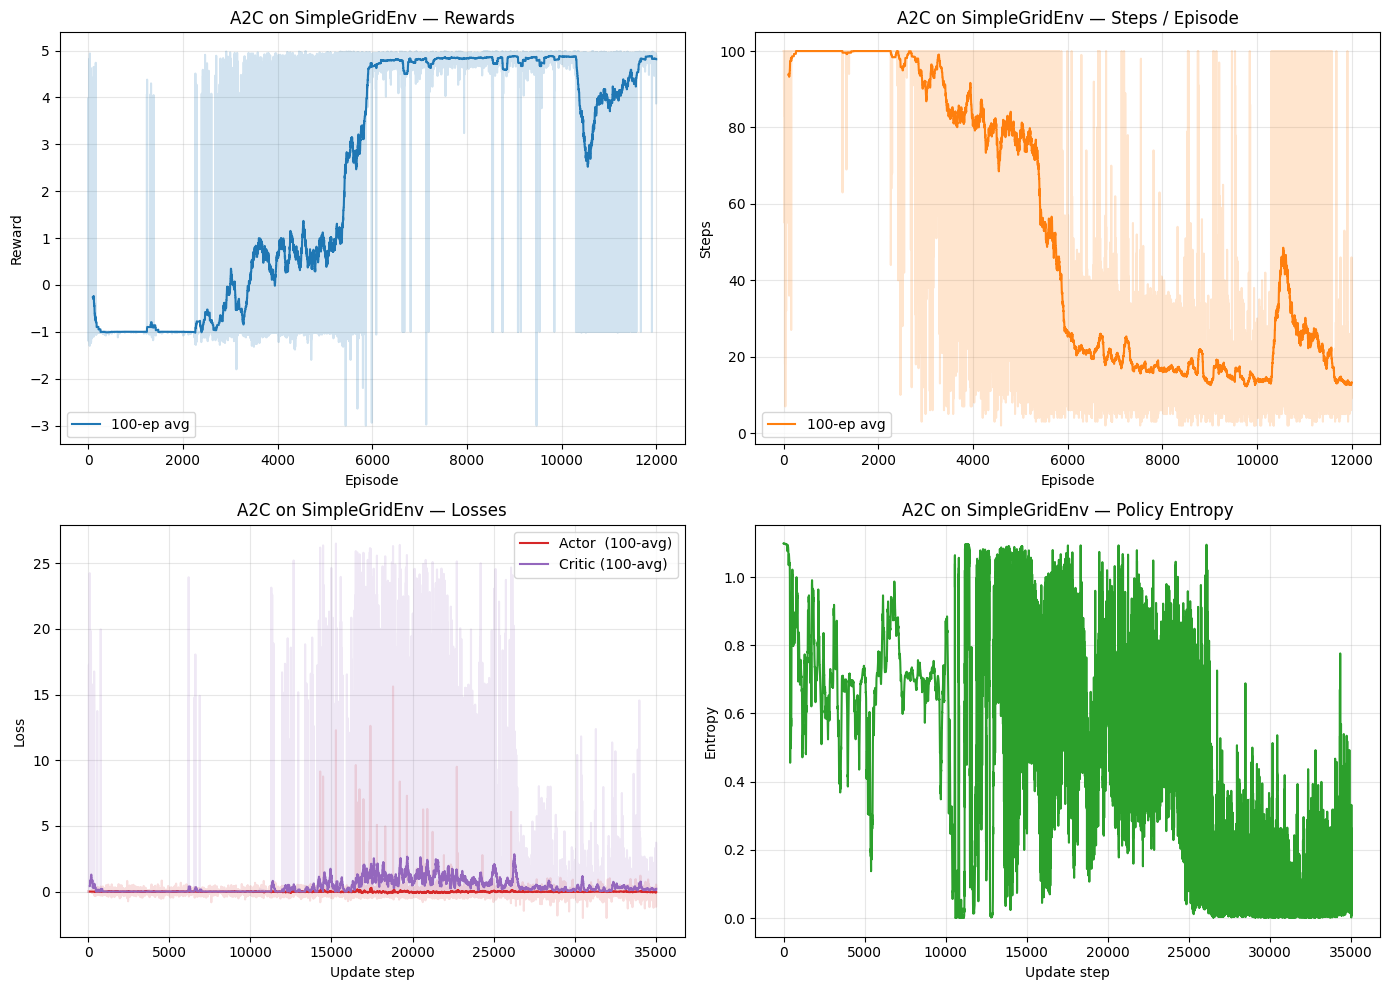

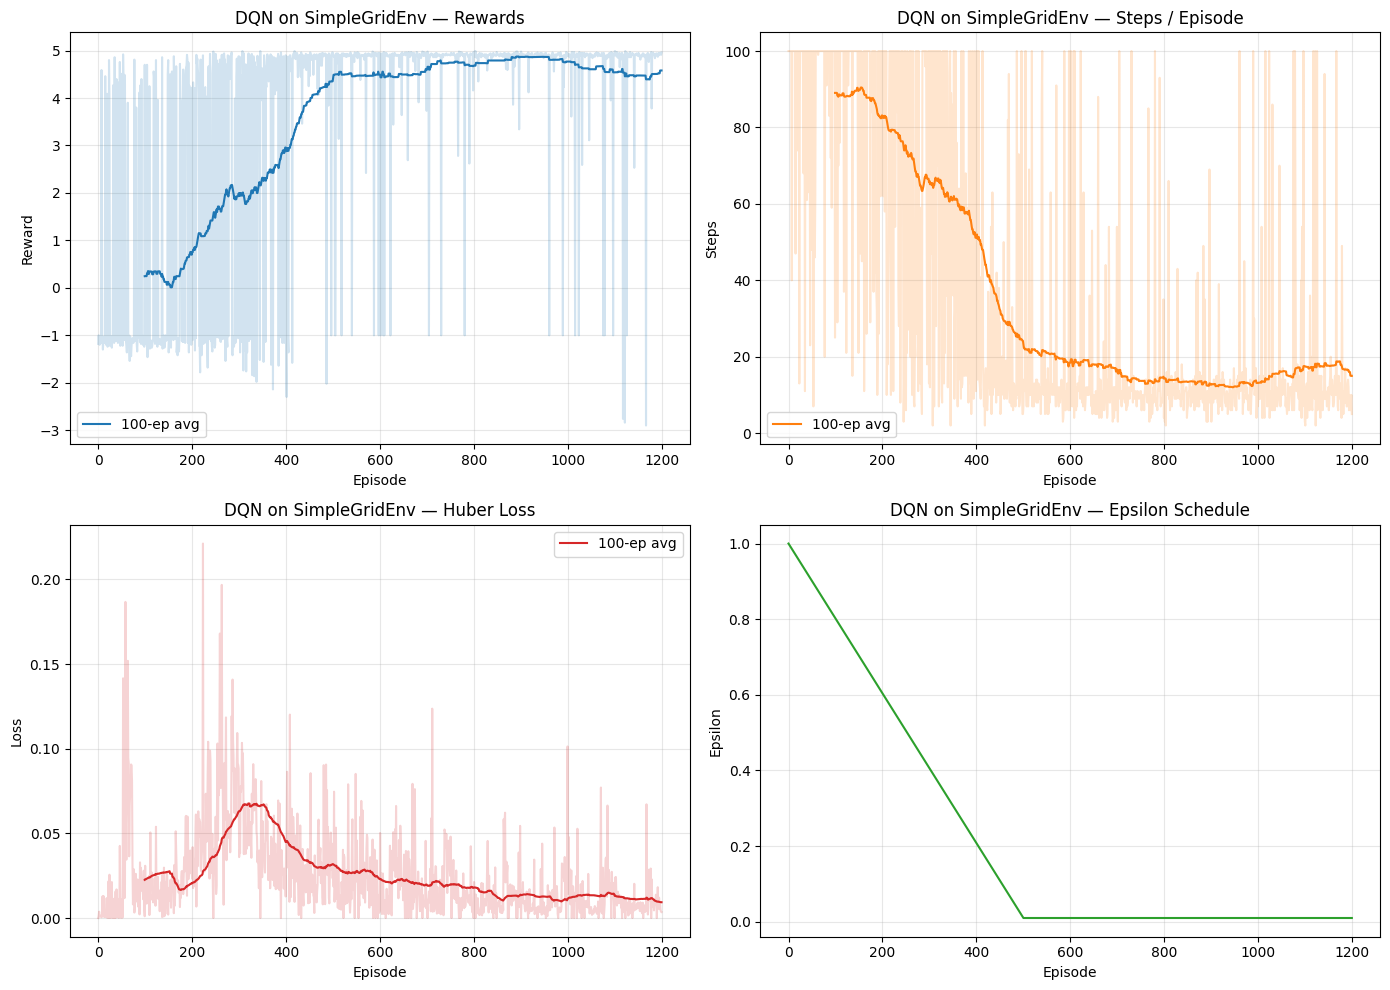

In [99]:
# ── Individual training curves per algorithm ─────────────────────────────────
for algo_name, data in simplegrid_results.items():
    plot_training(data["history"], title=f"{algo_name} on SimpleGridEnv")

### Evaluation (last 100 episodes)

In [100]:
for algo_name, data in simplegrid_results.items():
    results = evaluate_agent(
        agent=data["agent"],
        env_class=SimpleGridEnv,
        num_episodes=100,
        max_steps=data["config"]["max_steps"],
    )
    print_evaluation_results(results, title=f"{algo_name} on SimpleGridEnv — Evaluation")
    data["eval"] = results  # store for later comparison
    print()

Evaluating: |██████████████████████████████| 100/100 (100%) success so far: 97/100
 A2C on SimpleGridEnv — Evaluation
  Episodes evaluated:  100
  Success rate:        97.0%
------------------------------------------------------------
  Average reward:      4.703 +/- 1.123
  Average steps:       13.8 +/- 15.5
  Step range:          [4, 100]

Evaluating: |██████████████████████████████| 100/100 (100%) success so far: 100/100
 DQN on SimpleGridEnv — Evaluation
  Episodes evaluated:  100
  Success rate:        100.0%
------------------------------------------------------------
  Average reward:      4.912 +/- 0.030
  Average steps:       9.8 +/- 3.0
  Step range:          [2, 17]



## 4.3 Comparison

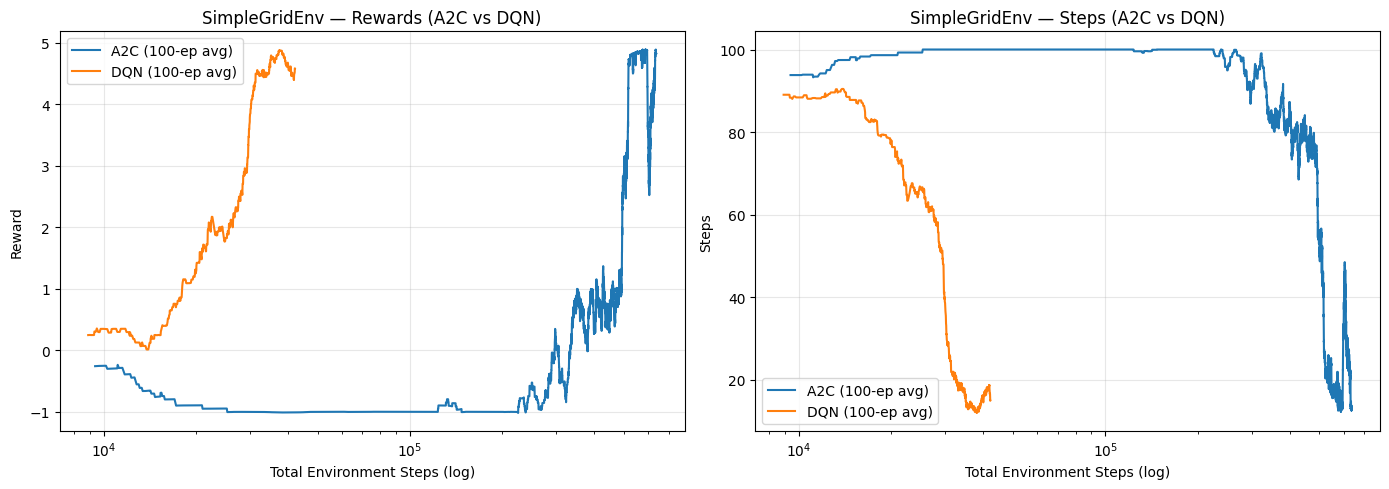


SimpleGridEnv — Last 100 Episodes
Algo        Avg R    Avg S   Success
-----------------------------------
A2C         4.703     13.8     97.0%
DQN         4.912      9.8    100.0%


In [101]:
# ── Compare on cumulative environment steps (fair x-axis) ────────────────
SMOOTHING_WINDOW = 100
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for algo, data in simplegrid_results.items():
    r = np.array(data["history"]["episode_rewards"])
    s = np.array(data["history"]["episode_steps"])
    cum_steps = np.cumsum(s)           # total env interactions so far

    if len(r) >= SMOOTHING_WINDOW:
        k = np.ones(SMOOTHING_WINDOW) / SMOOTHING_WINDOW
        sm_r = np.convolve(r, k, "valid")
        sm_s = np.convolve(s, k, "valid")
        x = cum_steps[SMOOTHING_WINDOW - 1:]   # align with smoothed values
        axes[0].plot(x, sm_r, label=f"{algo} ({SMOOTHING_WINDOW}-ep avg)")
        axes[1].plot(x, sm_s, label=f"{algo} ({SMOOTHING_WINDOW}-ep avg)")
    else:
        axes[0].plot(cum_steps, r, label=algo)
        axes[1].plot(cum_steps, s, label=algo)

axes[0].set_xscale("log"); axes[0].set_xlabel("Total Environment Steps (log)"); axes[0].set_ylabel("Reward")
axes[0].set_title("SimpleGridEnv — Rewards (A2C vs DQN)")
axes[0].legend(); axes[0].grid(True, alpha=0.3)
axes[1].set_xscale("log"); axes[1].set_xlabel("Total Environment Steps (log)"); axes[1].set_ylabel("Steps")
axes[1].set_title("SimpleGridEnv — Steps (A2C vs DQN)")
axes[1].legend(); axes[1].grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

print("\nSimpleGridEnv — Last 100 Episodes")
print(f"{'Algo':<8} {'Avg R':>8} {'Avg S':>8} {'Success':>9}")
print("-" * 35)
for algo, data in simplegrid_results.items():
    if "eval" in data:
        e = data["eval"]
        print(f"{algo:<8} {e['avg_reward']:>8.3f} {e['avg_steps']:>8.1f} {e['success_rate']*100:>8.1f}%")

## 4.4 Videos — Random, Mid-Training & Trained Agent

In [102]:
# Video — Random (untrained) agent baseline
random_vid = "outputs/simplegrid_random_agent.mp4"
record_video(
    agent=None,
    env_class=SimpleGridEnv,
    filename=random_vid,
    num_episodes=1,
    max_steps=100,
)
print("Random Agent (Before Training):")
display(embed_mp4(random_vid))

# Mid-training videos (recorded automatically during training)
import os
for algo_name in simplegrid_results:
    mid_vid = f"outputs/simplegrid_{algo_name.lower()}_midtraining.mp4"
    if os.path.exists(mid_vid):
        print(f"\n{algo_name} — Mid-Training:")
        display(embed_mp4(mid_vid))

Video saved: outputs/simplegrid_random_agent.mp4  (84 frames, 10 fps)
  Episodes: 1, Total steps: 83, Total reward: 4.10
Random Agent (Before Training):



A2C — Mid-Training:



DQN — Mid-Training:


In [103]:
# Record MP4 videos of the trained agents and display inline
for algo_name, data in simplegrid_results.items():
    vid_path = f"outputs/simplegrid_{algo_name.lower()}_trained.mp4"
    record_video(
        agent=data["agent"],
        env_class=SimpleGridEnv,
        filename=vid_path,
        num_episodes=1,
        max_steps=data["config"]["max_steps"],
    )
    display(embed_mp4(vid_path))

Video saved: outputs/simplegrid_a2c_trained.mp4  (11 frames, 10 fps)
  Episodes: 1, Total steps: 10, Total reward: 4.91


Video saved: outputs/simplegrid_dqn_trained.mp4  (9 frames, 10 fps)
  Episodes: 1, Total steps: 8, Total reward: 4.93


# 7. KeyDoorBallEnv Experiment

In [106]:
keydoor_results = {}

# ── Shared environment factory (used by both A2C and DQN) ──
def make_keydoor_env(max_steps=500, tile_size=10):
    base_env = KeyDoorBallEnv(preprocess=pre_process, max_steps=max_steps, tile_size=tile_size)
    return SmartRewardWrapper(base_env)

## 7.1 A2C for KeyDoorBallEnv

In [107]:
set_seed(SEED)

# ── A2C hyperparameters ─────────────────────────────────────────────────────
A2C_KEYDOOR_CONFIG = {
    "num_episodes": 25000,
    "max_steps": 500,
    "lr": 0.0005,
    "gamma": 0.99,
    "entropy_coef": 0.05,
    "value_coef": 0.5,
    "n_steps": 128,
    "max_grad_norm": 0.5,
    "print_every": 500,
    "tile_size": 10,
}

# ── Load from disk if available, otherwise train ──
_a2c_hist_path = "saved_models/a2c_keydoor_history.pkl"
_a2c_wt_path   = "saved_models/a2c_keydoor_weights.pt"

if os.path.exists(_a2c_hist_path) and os.path.exists(_a2c_wt_path):
    import pickle
    with open(_a2c_hist_path, "rb") as f:
        a2c_keydoor_history = pickle.load(f)
    a2c_keydoor_agent = A2CAgent(
        num_actions=5, device=device,
        lr=A2C_KEYDOOR_CONFIG["lr"], gamma=A2C_KEYDOOR_CONFIG["gamma"],
        entropy_coef=A2C_KEYDOOR_CONFIG["entropy_coef"],
        value_coef=A2C_KEYDOOR_CONFIG["value_coef"],
        n_steps=A2C_KEYDOOR_CONFIG["n_steps"],
    )
    _weights = torch.load(_a2c_wt_path, map_location=device)
    _target = a2c_keydoor_agent.model._orig_mod if hasattr(a2c_keydoor_agent.model, "_orig_mod") else a2c_keydoor_agent.model
    _target.load_state_dict(_weights)
    a2c_keydoor_agent.model.eval()
    print(f"Loaded A2C KeyDoor from disk  ({len(a2c_keydoor_history['episode_rewards'])} episodes)")
else:
    a2c_keydoor_env = make_keydoor_env(
        max_steps=A2C_KEYDOOR_CONFIG["max_steps"],
        tile_size=A2C_KEYDOOR_CONFIG["tile_size"],
    )
    a2c_keydoor_agent, a2c_keydoor_history = train_actor_critic(
        env_or_class=a2c_keydoor_env,
        device=device,
        video_at={"episode": A2C_KEYDOOR_CONFIG["num_episodes"] // 2,
                  "filename": "outputs/keydoor_a2c_midtraining.mp4"},
        **A2C_KEYDOOR_CONFIG,
    )

# ── Store results ──
keydoor_results["A2C"] = {
    "agent": a2c_keydoor_agent, "history": a2c_keydoor_history,
    "config": A2C_KEYDOOR_CONFIG,
}

Training A2C on KeyDoorBallEnv
Episodes: 25000, Max steps: 500, n_steps: 128
LR: 0.0005, Gamma: 0.99, Entropy coef: 0.05
Episode   500 | Avg Reward:   -1.748 | Avg Steps:  499.4 | Entropy: 1.103 | Running:   -2.363
Episode  1000 | Avg Reward:   -2.405 | Avg Steps:  500.0 | Entropy: 1.096 | Running:   -2.363
Episode  1500 | Avg Reward:   -2.105 | Avg Steps:  499.9 | Entropy: 1.089 | Running:   -1.861
Episode  2000 | Avg Reward:    0.274 | Avg Steps:  499.9 | Entropy: 1.427 | Running:    2.527
Episode  2500 | Avg Reward:   -0.670 | Avg Steps:  500.0 | Entropy: 1.138 | Running:   -2.144
Episode  3000 | Avg Reward:   -2.212 | Avg Steps:  500.0 | Entropy: 1.121 | Running:   -2.132
Episode  3500 | Avg Reward:   -2.323 | Avg Steps:  500.0 | Entropy: 1.114 | Running:   -2.438
Episode  4000 | Avg Reward:   -2.351 | Avg Steps:  500.0 | Entropy: 1.109 | Running:   -2.506
Episode  4500 | Avg Reward:    0.511 | Avg Steps:  500.0 | Entropy: 1.457 | Running:    1.521
Episode  5000 | Avg Reward:    2.

In [112]:
import pickle, os

os.makedirs("saved_models", exist_ok=True)

# ── Save A2C KeyDoorBall history + weights ──
with open("saved_models/a2c_keydoor_history.pkl", "wb") as f:
    pickle.dump(a2c_keydoor_history, f)

torch.save(a2c_keydoor_agent.model.state_dict(), "saved_models/a2c_keydoor_weights.pt")

print("Saved: a2c_keydoor_history.pkl, a2c_keydoor_weights.pt")

Saved: a2c_keydoor_history.pkl, a2c_keydoor_weights.pt


## 7.2 DQN for KeyDoorBallEnv

In [114]:
set_seed(SEED)

# ── DQN hyperparameters ─────────────────────────────────────────────────────
DQN_KEYDOOR_CONFIG = {
    "num_episodes":           8000,
    "max_steps":              500,
    "lr":                     3e-4,
    "gamma":                  0.99,
    "epsilon_start":          1.0,
    "epsilon_end":            0.05,
    "epsilon_decay_episodes": 5000,      # slow decay — exploration is critical
    "batch_size":             128,
    "replay_capacity":        200_000,
    "min_replay_size":        3000,
    "target_update_freq":     1000,
    "train_every":            4,
    "double_dqn":             True,
    "init_type":              "xavier",  # best in weight-init experiment
    "print_every":            100,
    "tile_size":              10,
    "save_checkpoint_at":     4000,      # mid-training video checkpoint
    # ── Milestone replay buffer ──
    "milestone_capacity":     20_000,    # small dedicated buffer for stage transitions
    "milestone_fraction":     0.25,      # 25% of each batch from milestone buffer
    "milestone_threshold":    0.5,       # |reward| > 0.5 → milestone (catches +5.0 stage rewards)
}

# ── Load from disk if available, otherwise train ──
_dqn_hist_path = "saved_models/dqn_keydoor_history.pkl"
_dqn_wt_path   = "saved_models/dqn_keydoor_weights.pt"

if os.path.exists(_dqn_hist_path) and os.path.exists(_dqn_wt_path):
    import pickle
    with open(_dqn_hist_path, "rb") as f:
        dqn_keydoor_history = pickle.load(f)
    dqn_keydoor_agent = DQNAgent(
        num_actions=5, device=device,
        lr=DQN_KEYDOOR_CONFIG["lr"], gamma=DQN_KEYDOOR_CONFIG["gamma"],
        epsilon_start=0.0, epsilon_end=0.0, epsilon_decay_episodes=1,
        target_update_freq=DQN_KEYDOOR_CONFIG["target_update_freq"],
    )
    _weights = torch.load(_dqn_wt_path, map_location=device)
    _target = dqn_keydoor_agent.q_net._orig_mod if hasattr(dqn_keydoor_agent.q_net, "_orig_mod") else dqn_keydoor_agent.q_net
    _target.load_state_dict(_weights)
    dqn_keydoor_agent.q_net.eval()
    dqn_keydoor_agent.epsilon = 0.0
    dqn_keydoor_mid_agent = None
    print(f"Loaded DQN KeyDoor from disk  ({len(dqn_keydoor_history['episode_rewards'])} episodes)")
else:
    keydoor_env = make_keydoor_env(
        max_steps=DQN_KEYDOOR_CONFIG["max_steps"],
        tile_size=DQN_KEYDOOR_CONFIG["tile_size"],
    )
    dqn_keydoor_agent, dqn_keydoor_history, dqn_keydoor_mid_agent = train_dqn(
        env_or_class=keydoor_env,
        device=device,
        video_at={"episode": DQN_KEYDOOR_CONFIG["num_episodes"] // 2,
                  "filename": "outputs/keydoor_dqn_midtraining.mp4"},
        **{k: v for k, v in DQN_KEYDOOR_CONFIG.items() if k != "tile_size"},
    )

# Store for comparison
keydoor_results["DQN"] = {
    "agent": dqn_keydoor_agent, "history": dqn_keydoor_history,
    "config": DQN_KEYDOOR_CONFIG,
}


Loaded DQN KeyDoor from disk  (6000 episodes)


In [ ]:
import pickle, os

os.makedirs("saved_models", exist_ok=True)

# ── Save DQN KeyDoorBall history + weights ──
with open("saved_models/dqn_keydoor_history.pkl", "wb") as f:
    pickle.dump(dqn_keydoor_history, f)

torch.save(dqn_keydoor_agent.q_net.state_dict(), "saved_models/dqn_keydoor_weights.pt")

print("Saved: dqn_keydoor_history.pkl, dqn_keydoor_weights.pt")

## 7.3 Comparison

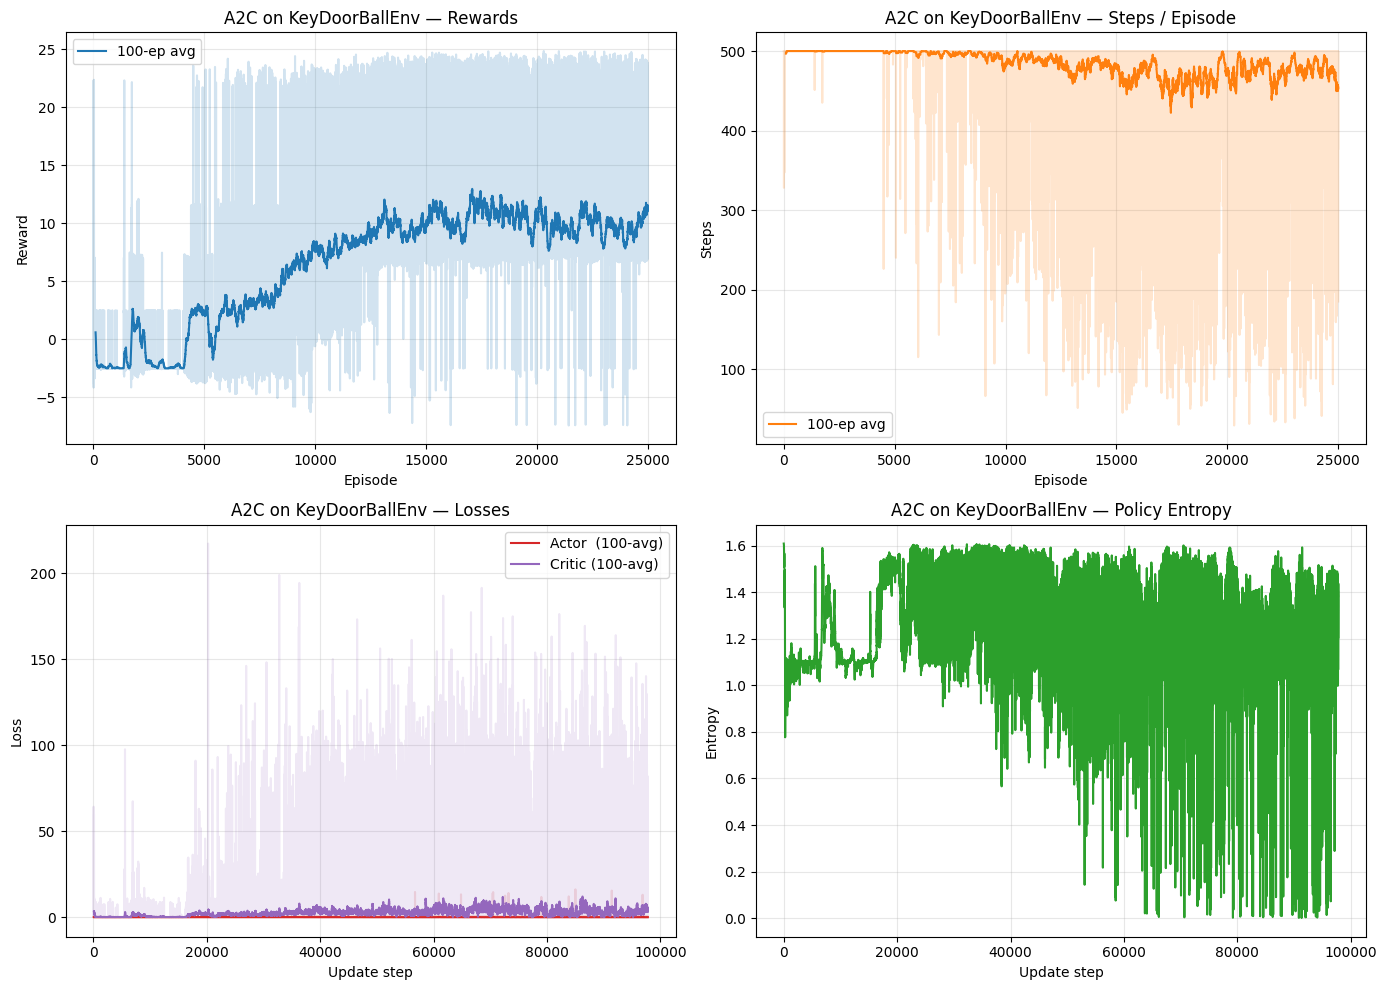

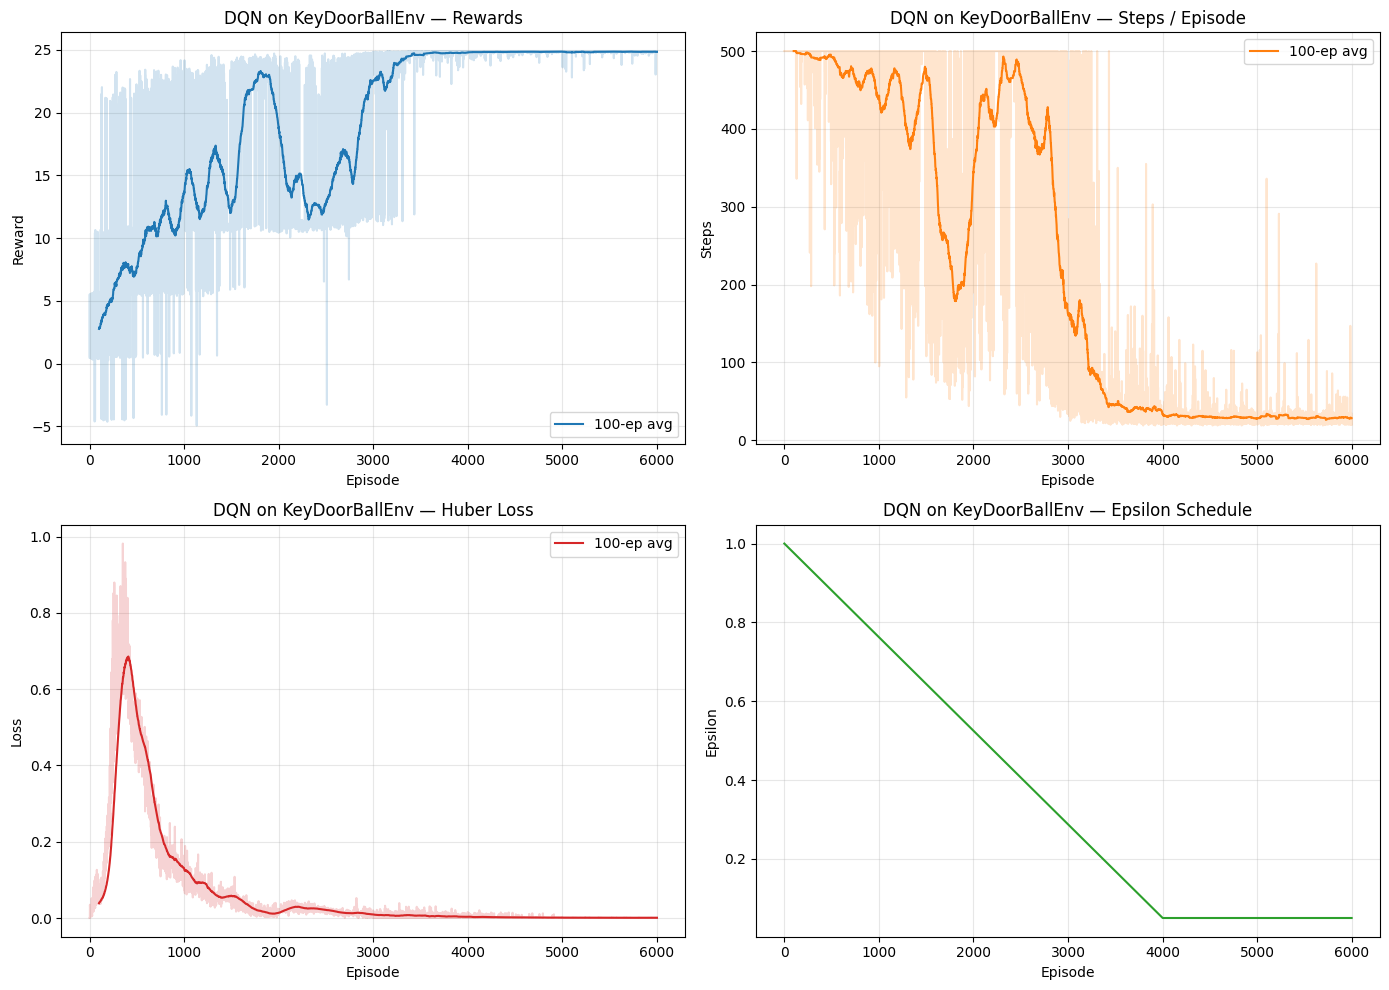

In [115]:
# Training curves
for algo_name, data in keydoor_results.items():
    plot_training(data["history"], title=f"{algo_name} on KeyDoorBallEnv")

In [116]:
# Evaluation (last 100 episodes)
for algo_name, data in keydoor_results.items():
    results = evaluate_agent(
        agent=data["agent"],
        env_class=KeyDoorBallEnv,
        num_episodes=100,
        max_steps=data["config"]["max_steps"],
    )
    data["eval"] = results
    print_evaluation_results(results, title=f"{algo_name} on KeyDoorBallEnv — Evaluation")
    print()

Evaluating: |██████████████████████████████| 100/100 (100%) success so far: 0/100
 A2C on KeyDoorBallEnv — Evaluation
  Episodes evaluated:  100
  Success rate:        0.0%
------------------------------------------------------------
  Average reward:      0.000 +/- 0.000
  Average steps:       500.0 +/- 0.0
  Step range:          [500, 500]

Evaluating: |██████████████████████████████| 100/100 (100%) success so far: 94/100
 DQN on KeyDoorBallEnv — Evaluation
  Episodes evaluated:  100
  Success rate:        94.0%
------------------------------------------------------------
  Average reward:      0.940 +/- 0.237
  Average steps:       54.3 +/- 112.7
  Step range:          [20, 500]



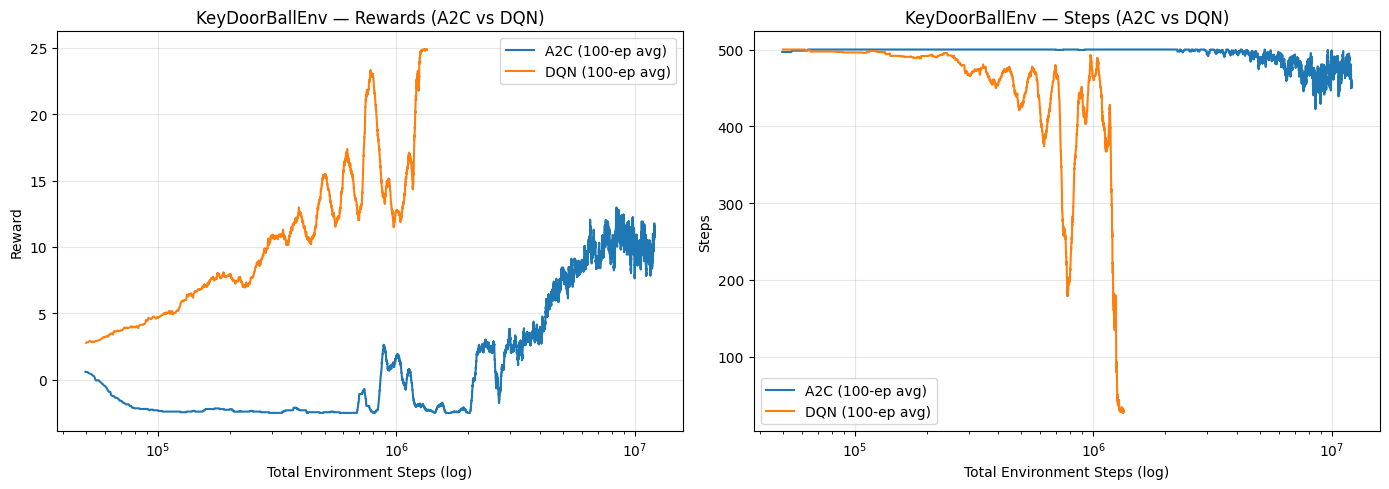


KeyDoorBallEnv — Last 100 Episodes
Algo        Avg R    Avg S   Success
-----------------------------------
A2C         0.000    500.0      0.0%
DQN         0.940     54.3     94.0%


In [117]:
# ── Compare on cumulative environment steps (fair x-axis) ────────────────
SMOOTHING_WINDOW = 100
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for algo, data in keydoor_results.items():
    r = np.array(data["history"]["episode_rewards"])
    s = np.array(data["history"]["episode_steps"])
    cum_steps = np.cumsum(s)

    if len(r) >= SMOOTHING_WINDOW:
        k = np.ones(SMOOTHING_WINDOW) / SMOOTHING_WINDOW
        sm_r = np.convolve(r, k, "valid")
        sm_s = np.convolve(s, k, "valid")
        x = cum_steps[SMOOTHING_WINDOW - 1:]
        axes[0].plot(x, sm_r, label=f"{algo} ({SMOOTHING_WINDOW}-ep avg)")
        axes[1].plot(x, sm_s, label=f"{algo} ({SMOOTHING_WINDOW}-ep avg)")
    else:
        axes[0].plot(cum_steps, r, label=algo)
        axes[1].plot(cum_steps, s, label=algo)

axes[0].set_xscale("log"); axes[0].set_xlabel("Total Environment Steps (log)"); axes[0].set_ylabel("Reward")
axes[0].set_title("KeyDoorBallEnv — Rewards (A2C vs DQN)")
axes[0].legend(); axes[0].grid(True, alpha=0.3)
axes[1].set_xscale("log"); axes[1].set_xlabel("Total Environment Steps (log)"); axes[1].set_ylabel("Steps")
axes[1].set_title("KeyDoorBallEnv — Steps (A2C vs DQN)")
axes[1].legend(); axes[1].grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# ── Evaluation table ──
print("\nKeyDoorBallEnv — Last 100 Episodes")
print(f"{'Algo':<8} {'Avg R':>8} {'Avg S':>8} {'Success':>9}")
print("-" * 35)
for algo, data in keydoor_results.items():
    if "eval" in data:
        e = data["eval"]
        print(f"{algo:<8} {e['avg_reward']:>8.3f} {e['avg_steps']:>8.1f} {e['success_rate']*100:>8.1f}%")

## 7.4 Videos — Random, Mid-Training & Trained Agent

In [118]:
# Video — Random (untrained) agent baseline
random_vid = "outputs/keydoor_random_agent.mp4"
max_steps_vid = list(keydoor_results.values())[0]["config"]["max_steps"]
record_video(
    agent=None, env_class=KeyDoorBallEnv,
    filename=random_vid, num_episodes=1,
    max_steps=max_steps_vid,
)
print("Random Agent (Before Training):")
display(embed_mp4(random_vid))

# Mid-training & trained videos for each algorithm
for algo_name, data in keydoor_results.items():
    algo_lower = algo_name.lower()

    mid_vid = f"outputs/keydoor_{algo_lower}_midtraining.mp4"
    if os.path.exists(mid_vid):
        print(f"\n{algo_name} — Mid-Training:")
        display(embed_mp4(mid_vid))

    trained_vid = f"outputs/keydoor_{algo_lower}_trained.mp4"
    record_video(
        agent=data["agent"], env_class=KeyDoorBallEnv,
        filename=trained_vid, num_episodes=1,
        max_steps=data["config"]["max_steps"],
    )
    print(f"\n{algo_name} — Trained Agent:")
    display(embed_mp4(trained_vid))

Video saved: outputs/keydoor_random_agent.mp4  (501 frames, 10 fps)
  Episodes: 1, Total steps: 500, Total reward: 0.00
Random Agent (Before Training):



A2C — Mid-Training:


Video saved: outputs/keydoor_a2c_trained.mp4  (501 frames, 10 fps)
  Episodes: 1, Total steps: 500, Total reward: 0.00

A2C — Trained Agent:



DQN — Mid-Training:


Video saved: outputs/keydoor_dqn_trained.mp4  (21 frames, 10 fps)
  Episodes: 1, Total steps: 20, Total reward: 1.00

DQN — Trained Agent:


# 8. Experiments

Training DQN with identical hyperparameters under three init schemes.
Reduced episodes (1500) to keep runtime manageable while showing convergence trends.


  Weight Init: xavier
Training Double DQN on KeyDoorBallEnv
Episodes: 1500, Max steps: 300, LR: 0.0003, Gamma: 0.99
Batch: 128, Replay: 100000, eps: 1.0->0.02 over 1500 eps
Target update: 1000 steps, Train every: 4 steps, Init: xavier, Device: cuda
  *** First solve at episode 110 (steps=162, reward=14.87) ***
Ep   500 | Avg R:    0.247 | Avg S:  287.1 | Loss: 0.0182 | eps: 0.674 | Solves: 68/500
Ep  1000 | Avg R:    7.450 | Avg S:  240.7 | Loss: 0.0472 | eps: 0.347 | Solves: 245/500
Ep  1500 | Avg R:    8.837 | Avg S:  213.1 | Loss: 0.0290 | eps: 0.021 | Solves: 290/500
Training complete!
Last 500 eps — Avg R: 8.837, Avg S: 213.1
First solved at episode: 110

  Weight Init: kaiming
Training Double DQN on KeyDoorBallEnv
Episodes: 1500, Max steps: 300, LR: 0.0003, Gamma: 0.99
Batch: 128, Replay: 100000, eps: 1.0->0.02 over 1500 eps
Target update: 1000 steps, Train every: 4 steps, Init: kaiming, Device: cuda
  *** First solve at episode 116 (steps=251, reward=13.68) ***
Ep   500 | Avg R

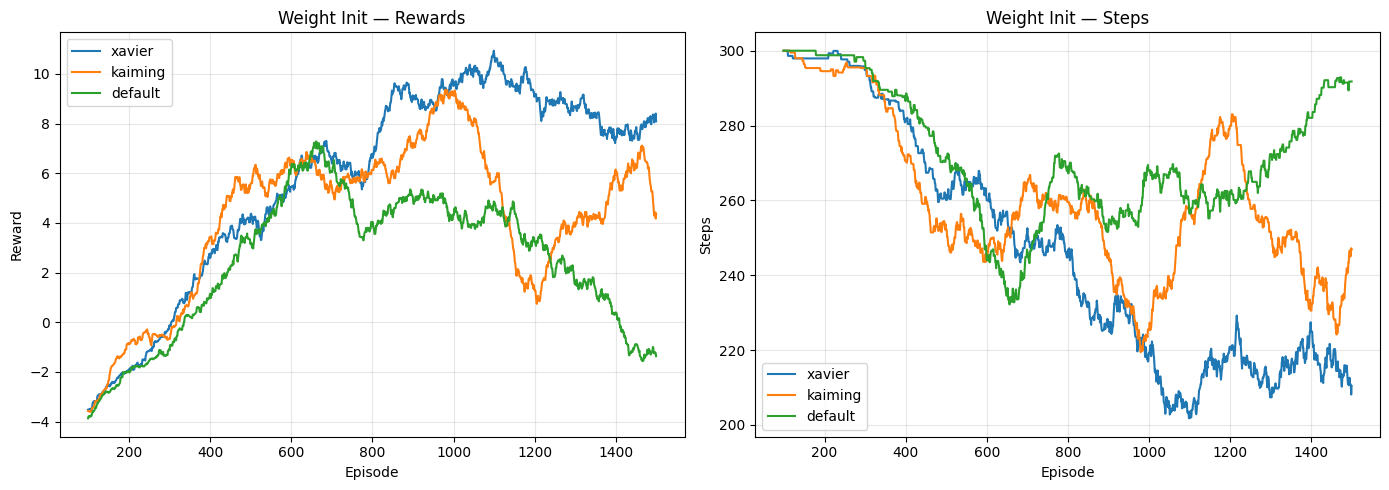


Weight Init Results (KeyDoorBallEnv)
Init        1st Solved  Last-100 R  Last-100 S
---------------------------------------------
xavier             110       8.086       210.4
kaiming            116       4.373       246.9
default            179      -1.364       291.8


In [ ]:
# =====================================================================
# Weight Init Experiment
# =====================================================================
INIT_EXPERIMENT_EPS = 1500
init_results = {}

for init_name in ["xavier", "kaiming", "default"]:
    print(f"\n{'='*60}\n  Weight Init: {init_name}\n{'='*60}")
    set_seed(SEED)
    exp_env = make_keydoor_env(
        max_steps=DQN_KEYDOOR_CONFIG["max_steps"],
        tile_size=DQN_KEYDOOR_CONFIG["tile_size"],
    )
    _, hist, _ = train_dqn(
        env_or_class=exp_env,
        num_episodes=INIT_EXPERIMENT_EPS,
        max_steps=DQN_KEYDOOR_CONFIG["max_steps"],
        lr=DQN_KEYDOOR_CONFIG["lr"],
        gamma=DQN_KEYDOOR_CONFIG["gamma"],
        epsilon_start=DQN_KEYDOOR_CONFIG["epsilon_start"],
        epsilon_end=DQN_KEYDOOR_CONFIG["epsilon_end"],
        epsilon_decay_episodes=min(DQN_KEYDOOR_CONFIG["epsilon_decay_episodes"], INIT_EXPERIMENT_EPS),
        batch_size=DQN_KEYDOOR_CONFIG["batch_size"],
        replay_capacity=DQN_KEYDOOR_CONFIG["replay_capacity"],
        min_replay_size=DQN_KEYDOOR_CONFIG["min_replay_size"],
        target_update_freq=DQN_KEYDOOR_CONFIG["target_update_freq"],
        train_every=DQN_KEYDOOR_CONFIG["train_every"],  # ★ pass train_every
        init_type=init_name,
        print_every=500,
        device=device,
    )
    init_results[init_name] = hist

# -- Overlay plot --
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
SM = 100
for name, h in init_results.items():
    r, s = h["episode_rewards"], h["episode_steps"]
    if len(r) >= SM:
        k = np.ones(SM)/SM
        x = range(SM-1, len(r))
        axes[0].plot(x, np.convolve(r, k, "valid"), label=name)
        axes[1].plot(x, np.convolve(s, k, "valid"), label=name)

axes[0].set_xlabel("Episode"); axes[0].set_ylabel("Reward")
axes[0].set_title("Weight Init — Rewards"); axes[0].legend(); axes[0].grid(True, alpha=0.3)
axes[1].set_xlabel("Episode"); axes[1].set_ylabel("Steps")
axes[1].set_title("Weight Init — Steps"); axes[1].legend(); axes[1].grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# Summary table
print("\nWeight Init Results (KeyDoorBallEnv)")
print(f"{'Init':<10} {'1st Solved':>11} {'Last-100 R':>11} {'Last-100 S':>11}")
print("-" * 45)
for name, h in init_results.items():
    print(f"{name:<10} {str(h.get('first_solved_episode','N/A')):>11} "
          f"{np.mean(h['episode_rewards'][-100:]):>11.3f} "
          f"{np.mean(h['episode_steps'][-100:]):>11.1f}")

